# 3 Dimensional Tracer Inversion with spatial averaging

The goal of this notebook is to estimate the diffusivity tensor in an oceanic channel simulation with a ridge. 

The tracer was initialized with different, attempting to be orthogonal, initial patterns and advected in the 5km resolution run for 1 month.  

## Model Setup 

The zonal channel model is forced using winds (sinusoidal wind ; *not sin^2 like the other paper*) and linear buoyancy restoration at the surface. The north, south and bottom boundaries are insulating and stress free. The physical model is run to equilibrium (101 years), before introducing tracers into the domain. 

In [1]:
# load modules 

import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
import os 
from xgcm import Grid
import copy
from scipy.linalg import pinv, eig

In [2]:
# Aux functions (can put into python script)

# Function to calculate the gradients 
def tracer_grads(ds, ds_full):
    
    grid = Grid(ds_full, periodic='X')
    
    dx = ds_full.dxC.mean('YC')
    dy = ds_full.dyC.mean('XC')
    dz = ds_full.drF
    
    trac_dx = grid.interp(grid.diff(ds,'X')/dx, 'X')
    
    trac_dy = grid.interp(grid.diff(ds,'Y', boundary = 'extend')/dy, 'Y',boundary='extend')
    
    trac_dz = - grid.interp(grid.diff(ds,'Z', boundary = 'extend'), 'Z',boundary='extend')/dz  # dz is vector, dy is scalar

    trac_dx= trac_dx.rename('dcdx')
    trac_dy= trac_dy.rename('dcdy')
    trac_dz= trac_dz.rename('dcdz')
    
    grads = xr.merge([trac_dx, trac_dy, trac_dz])
    return grads

In [3]:
data_dir = '/swot/SUM05/dbalwada/channel_model_output/varying_res/05km/multi_tracer_montly_restored/multi_tracer/'

#Don't save the model output at such high frequency in the future! 

# use longer time series in final
# iters = range(10473120, 10473120+518400*4, 1440)  # *4 for 20 years
#
iters = range(10473120, 10473120+518400, 1440) # timestep iteration numbers, start, stop, step
model_vars = ['uVeltave','vVeltave','wVeltave', 
              'Ttave','UTtave','VTtave', 'WTtave']
ds_model = open_mdsdataset(data_dir , delta_t=300, iters=iters, 
                          prefix=model_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

/home/ssmith/.conda/envs/pangeo/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/utils.py:429: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [5]:
save_av = 0
Model_tav = ds_model.mean('time')  # xarray. average every variable with a time-axis along time
Model_tav.load()

if save_av:
    Model_tav.to_netcdf('5km_vars_tav.nc')

In [48]:
print(Model_tav)

<xarray.Dataset>
Dimensions:   (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40)
Coordinates:
  * XC        (XC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * YC        (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG        (XG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * YG        (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
    rA        (YC, XC) >f4 25000000.0 25000000.0 ... 25000000.0 25000000.0
    dxG       (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    dyG       (YC, XG) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    Depth     (YC, XC) >f4 0.0 

In [37]:
X = ds_model.XC 
Y = ds_model.YC 
Z = ds_model.Z 

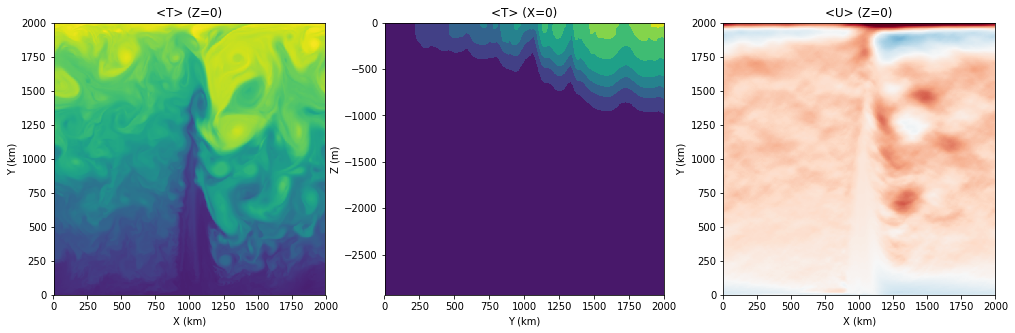

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

ax[0].pcolormesh(X/1e3, Y/1e3, ds_model.Ttave.isel(time=-1, Z=0))
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
ax[0].set_title('<T> (Z=0)')
ax[0].set_aspect('equal')

ax[1].contourf(Y/1e3, Z, ds_model.Ttave.isel(time=-1, XC=0))
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Z (m)')
ax[1].set_title('<T> (X=0)')

ax[2].pcolormesh(X/1e3, Y/1e3, Model_tav.uVeltave.isel(Z=0), vmin=-0.4, vmax=0.4, cmap='RdBu_r')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')
ax[2].set_title('<U> (Z=0)')
ax[2].set_aspect('equal')


### Tracer initializations and runs

We would like the model to solve the tracer advection-diffusion equation,
\begin{equation}
\frac{\partial c}{\partial t} + \mathbf{u}.\nabla c = 0,
\end{equation}
using the model generated velocity fields. The important thing to note is that there are no source of sinks of tracers on the RHS. 

If we split the variables into the mean and the eddy terms, $c = C + c'$ , then we get an equation for the mean tracer, 
\begin{equation}
\frac{\partial C}{\partial t} + \mathbf{U}. \nabla C = -\nabla.(\overline{\mathbf{u'}c'}).
\end{equation}
The goal of a tracer eddy parameterization scheme is to represent the eddy flux on the RHS. 

The eddy diffusivity tensor is used to parameterize the eddy flux as,
\begin{equation}
\overline{\mathbf{u'}c'} = - \mathbf{K} \nabla C.
\end{equation}
It is assumed that the same $\mathbf{K}$ applies to all the tracers. This might not be true if different tracers have different source functions. This expression is a 3 equation set, so if we had 3 different different (orthogonal) tracer gradients then we can invert this equation for the $\mathbf{K}$. Here we over fit the problem by using 10 different tracers. (** add some plots for different tracer orientations**)

As we are not using any forcing function to maintain the tracer gradeints, the flow field will mix away all the gradients as time progresses. So, instead of waiting for a long time we carry out an ensemble of simulations, where each tracer field is restarted every month (30 days). We carry out these monthly re-release experiments for 20 years, implying 240 tracer release experiments (** probably some sort of convergence test can be done for the statistics of the fluxes.**). 

It seems that the tracer fluxes are known to within 1% of their true values (5-10% for vertical flux) in 20 years. This implies, that it might not be required to do a spatial averaging on the data. 

## Initial condition for tracers:

$$C1 = yg/Lx$$
$$C2 = (-zg)/H$$
$$C3 = xg/Lx$$
$$C4 = np.cos(np.pi*yg/Lx)  *np.cos(np.pi*zg/H)  *np.cos(np.pi*xg/Lx)$$
$$C5 = np.sin(np.pi*yg/Lx)  *np.sin(np.pi*zg/H)  *np.sin(np.pi*xg/Lx)$$
$$C6 = np.sin(np.pi*yg/Lx)  *np.sin(2*np.pi*zg/H)*np.sin(np.pi*xg/Lx)$$
$$C7 = np.cos(2*np.pi*yg/Lx)*np.cos(np.pi*zg/H)*np.cos(np.pi*xg/Lx)$$
$$C8 = np.sin(np.pi*yg/Lx)*np.sin(np.pi*zg/H)*np.sin(2*np.pi*xg/Lx)$$
$$C9 = np.cos(2*np.pi*yg/Lx)*np.cos(2*np.pi*zg/H)*np.cos(2*np.pi*xg/Lx)$$
$$C10 = np.sin(2*np.pi*yg/Lx)*np.sin(2*np.pi*zg/H)*np.sin(2*np.pi*xg/Lx)$$

In [32]:
# Load tracer files that have been time averaged
tav_trac = xr.open_dataset('/home/dbalwada/3D_tracer_inversion/tav_trac.nc')

In [21]:
# Grid variable to calculate interpolations and derivatives
grid = Grid(ds_model, periodic='X')

# Some lists that will be used later for looping over variables.
list_tracers = ['TRAC01', 'TRAC02','TRAC03','TRAC04',
                'TRAC05','TRAC06','TRAC07','TRAC08','TRAC09','TRAC10']
list_vels = ['uVeltave','vVeltave','wVeltave']
vels = {'uVeltave':'U', 'vVeltave':'V', 'wVeltave':'W'}

In [22]:
X = tav_trac.XC
Y = tav_trac.YC
Z = tav_trac.Z

Text(0.5, 0.98, '<Tracers> (Z=0)')

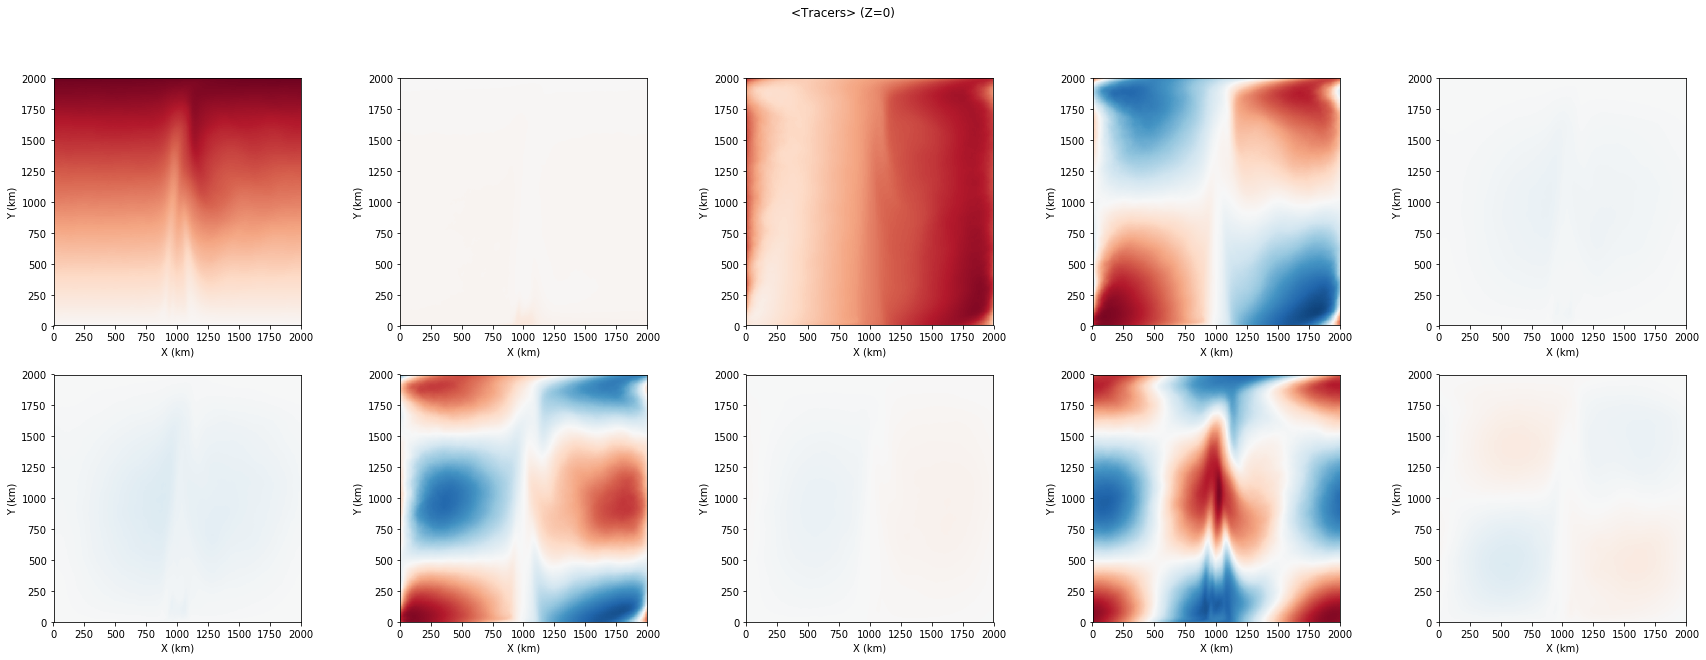

In [45]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10), squeeze=True)
axf = ax.flatten()
n=0
for key in list_tracers: 
    axf[n].pcolormesh(X/1e3, Y/1e3, tav_trac[key].sel(Z=0, method='nearest'), vmin=-1, vmax=1, cmap='RdBu_r')
    axf[n].set_xlabel('X (km)')
    axf[n].set_ylabel('Y (km)')
    axf[n].set_aspect('equal')
    n+=1
fig.suptitle('<Tracers> (Z=0)')

Text(0.5, 0.98, '<Tracers> (X=50)')

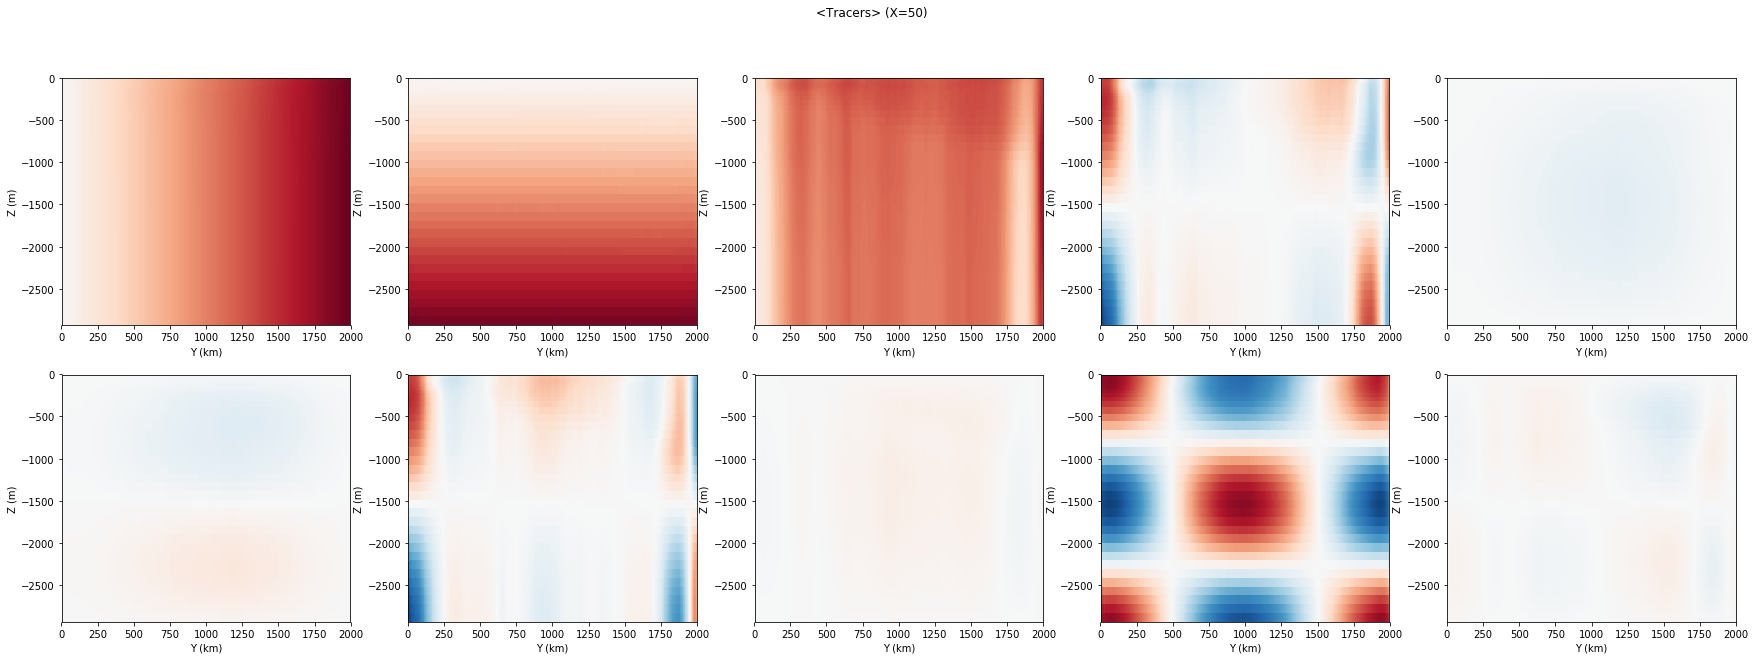

In [46]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10), squeeze=True)
axf = ax.flatten()
n=0
for key in list_tracers: 
    axf[n].pcolormesh(Y/1e3, Z, tav_trac[key].sel(XC=50, method='nearest'), vmin=-1, vmax=1, cmap='RdBu_r')
    axf[n].set_xlabel('Y (km)')
    axf[n].set_ylabel('Z (m)')
    n+=1
fig.suptitle('<Tracers> (X=50)')

Text(0.5, 0.98, '<Tracers> (Y=50,000)')

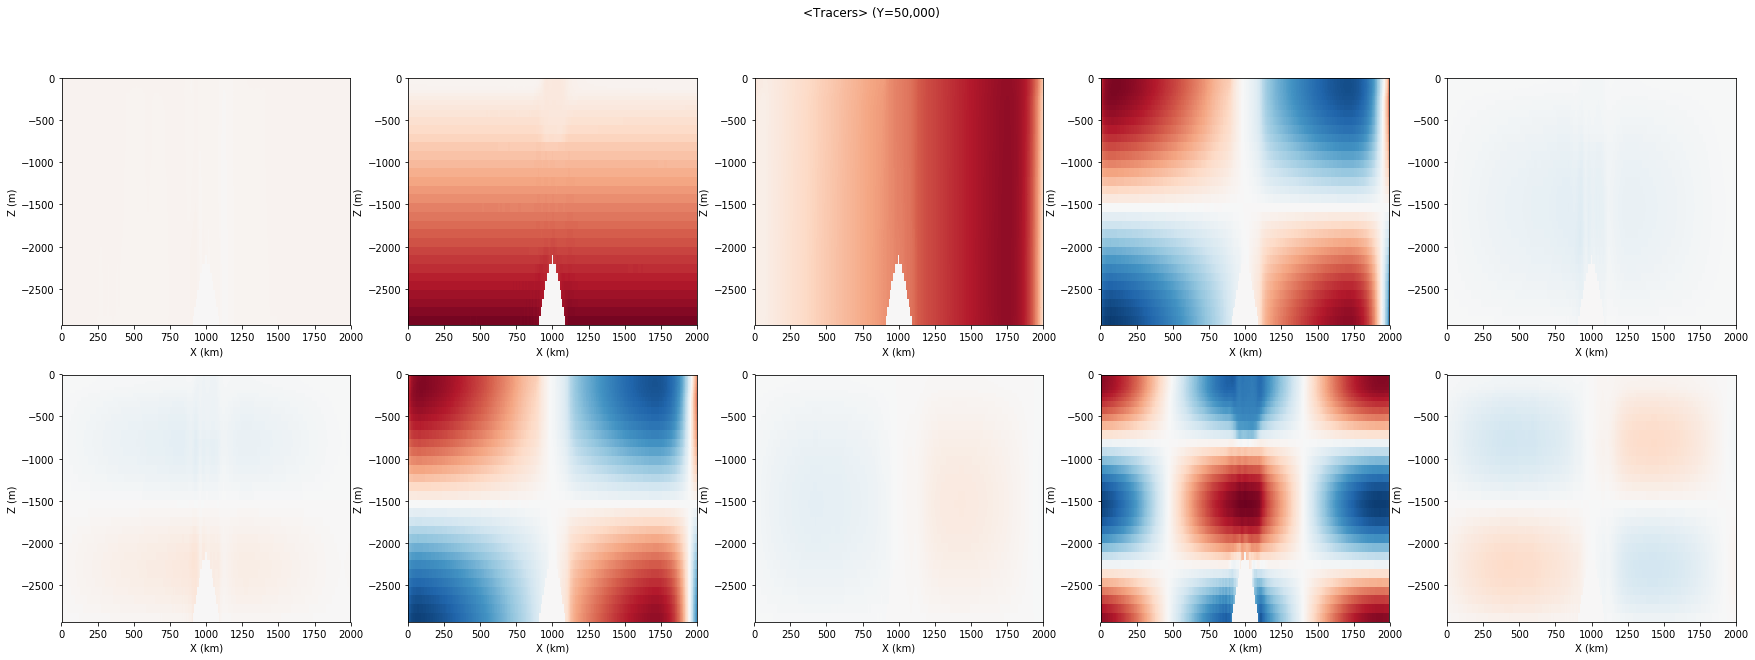

In [47]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10), squeeze=True)
axf = ax.flatten()
n=0
for key in list_tracers: 
    axf[n].pcolormesh(X/1e3, Z, tav_trac[key].sel(YC=50e3, method='nearest'), vmin=-1, vmax=1, cmap='RdBu_r')
    axf[n].set_xlabel('X (km)')
    axf[n].set_ylabel('Z (m)')
    n+=1
fig.suptitle('<Tracers> (Y=50,000)')

# Pseudo inversion to calculate the diffusivity

Here we want to invert the following equation 

\begin{equation} 
\overline{\mathbf{u}'c'} = - \mathbf{K} \nabla C
\end{equation}

The averages are time + spatial average. 
 
A better averaging implementation of the averaging is here
https://gist.github.com/rabernat/70c27dee9f8096c5602ea64e6ced1892 
Can be included in future versions. 

In [56]:
# Define the coarse grid

Lcoarse = 400e3 # needs to be a multiple of the domain size. 100e3 => idmax=nreps=20
idmax   = int( (Model_tav.dyC[0,0].values * len(Model_tav.YC))/Lcoarse) # numper of grid points to average over
nreps   = int( len(Model_tav.YC)/idmax )

YCicoarse = np.repeat(range(idmax),nreps)  # like matlab repmat
XCicoarse = np.repeat(range(idmax),nreps)

In [64]:
# Interpolate mean velocities to all be on same point.
Model_tav['WmeanC'] = grid.interp(Model_tav.wVeltave, 'Z', boundary='extend') # grid = xgcm.Grid, on which .interp, .diff, .cumsum work.
Model_tav['VmeanC'] = grid.interp(Model_tav.vVeltave, 'Y', boundary='extend') # .interp shifts grid nodes on C-grid, I think?
Model_tav['UmeanC'] = grid.interp(Model_tav.uVeltave, 'X')

In [79]:
grid

<xgcm.Grid>
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
T Axis (not periodic):
  * center   time
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center

In [65]:
Model_tav.coords['XCicoarse'] = ('XC', XCicoarse)  # 'XC' is dimension, XCicoarse is actual data in the coordinate
Model_tav.coords['YCicoarse'] = ('YC', YCicoarse)

In [80]:
print(YCicoarse)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [42]:
# coarse-grain mean velocities

Vels_coarse = xr.Dataset()

# in below, vels = {'uVeltave':'U', 'vVeltave':'V', 'wVeltave':'W'}, and +'meanC' gives things like 'UmeanC'
# groupby is binning all values of data with same YCicoarse, then averaging them.  Basically coarsegraining..

for i in vels:
    Vels_coarse[vels[i]] = (Model_tav[vels[i]+'meanC'].groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')

Vels_coarse.coords['YCcoarse'] = ('YCicoarse', Model_tav.YC.groupby('YCicoarse').mean('YC'))
Vels_coarse.coords['XCcoarse'] = ('XCicoarse', Model_tav.XC.groupby('XCicoarse').mean('XC'))

In [50]:
for key in list_tracers: 
        tav_trac['V'+key] = grid.interp(tav_trac['V'+key], 'Y', boundary='extend')

In [51]:
for key in list_tracers: 
        tav_trac['U'+key] = grid.interp(tav_trac['U'+key], 'X')

In [53]:
tav_trac.coords['Yicoarse'] = ('YC', Yicoarse)
tav_trac.coords['Xicoarse'] = ('XC', Xicoarse)
tracsav = tav_trac.groupby('Yicoarse').mean('YC')
tracsav = tracsav.groupby('Xicoarse').mean('XC')
tracsav.coords['Ycoarse'] = ('Yicoarse', tav_trac.YC.groupby('Yicoarse').mean('YC'))
tracsav.coords['Xcoarse'] = ('Xicoarse', tav_trac.XC.groupby('Xicoarse').mean('XC'))

In [56]:
# flux datasets 
mean_flux_stxav = xr.Dataset()   # create empty dataset

for i in list_tracers: 
    mean_flux_stxav['U'+i] = tracsav['U'+i] - Umeansav * tracsav[i]    
    mean_flux_stxav['V'+i] = tracsav['V'+i] - Vmeansav * tracsav[i]
    mean_flux_stxav['W'+i] = tracsav['W'+i] - Wmeansav * tracsav[i]

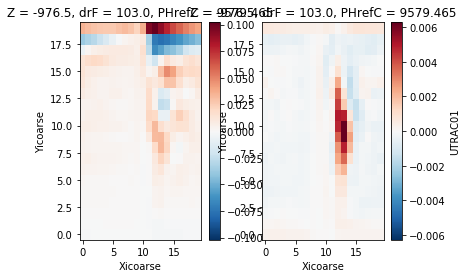

In [462]:
plt.subplot(121)
tracsav['UTRAC01'].sel(Z=-1000, method='nearest').plot(x='Xicoarse',y='Yicoarse')

plt.subplot(122)
mean_flux_stxav['UTRAC01'].sel(Z=-1000, method='nearest').plot(x='Xicoarse',y='Yicoarse')

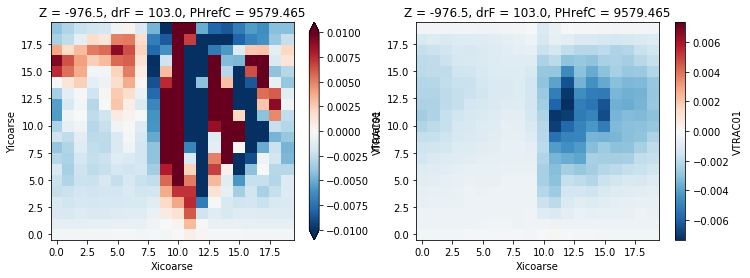

In [465]:
plt.figure(figsize=(12,4))
plt.subplot(121)
tracsav['VTRAC01'].sel(Z=-1000, method='nearest').plot(x='Xicoarse',y='Yicoarse', vmin=-0.01)

plt.subplot(122)
mean_flux_stxav['VTRAC01'].sel(Z=-1000, method='nearest').plot(x='Xicoarse',y='Yicoarse')

In [67]:
# make staggered coordinates
temp = np.repeat(idmax, nreps/2)
temp2 = np.repeat(idmax-1, nreps/2)
Yicstag = np.concatenate([Yicoarse[int(nreps/2):], temp])
Xicstag = np.concatenate([temp2, Xicoarse[:-int(nreps/2)]])

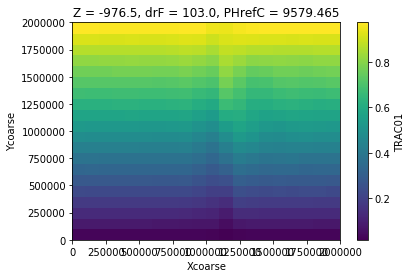

In [152]:
tracsav.TRAC01.sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')

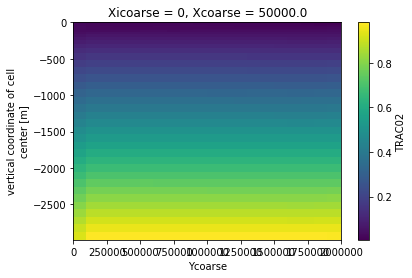

In [162]:
tracsav.TRAC02.sel(Xicoarse=0, method='nearest').plot(x='Ycoarse',y='Z')

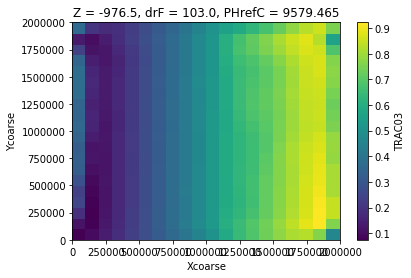

In [154]:
tracsav.TRAC03.sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')

In [74]:
# started working on getting things to work like xgcm
#dstemp = xr.Dataset(coords = {'x_c':(['x_c',], Xicoarse),
#                              'x_l':(['x_l',], Xicstag,
#                                     {'axis': 'X', 'c_grid_axis_shift': -0.5}),
#                              'y_c':(['y_c',], Yicoarse),
#                              'y_o':(['y_o',], Yicstag),})

In [77]:
trac_stag = xr.Dataset()

for i in list_tracers: 
    trac_stag[i] = tav_trac[i]

In [79]:
trac_stag.coords['Xicstag'] = ('XC', Xicstag)
trac_stag.coords['Yicstag'] = ('YC', Yicstag)

In [82]:
tracsav_stag = trac_stag.groupby('Xicstag').mean('XC')
tracsav_stag = tracsav_stag.groupby('Yicstag').mean('YC')

In [145]:
# gradients on coarse grid
trac_grads = xr.Dataset()

# Z grads
for i in list_tracers:
    trac_grads[i+'_Z'] = -grid.diff(grid.interp(tracsav[i], 'Z', boundary='extend'),
                                    'Z', boundary='extend')/tracsav.drF
    
# Y grads 
# only average in Y direction on staggered points to take Y average. 
# average in X direction is on center points
trac_stag.coords['Yicstag'] = ('YC', Yicstag)
tracsav_stag = trac_stag.groupby('Yicstag').mean('YC')
tracsav_stag = tracsav_stag.groupby('Xicoarse').mean('XC')

for i in list_tracers:
    temp = tracsav_stag[i].diff('Yicstag')/Lcoarse
    
    temp = xr.DataArray(temp.data, dims=['Xicoarse', 'Yicoarse', 'Z'],
                       coords=[trac_grads.Xicoarse, trac_grads.Yicoarse, trac_grads.Z])
    
    trac_grads[i+'_Y'] = temp
    
# X grads 
# only averate in X direction on center points
trac_stag.coords['Xicstag'] = ('XC', Xicstag)
tracsav_stag = trac_stag.groupby('Yicoarse').mean('YC')
tracsav_stag = tracsav_stag.groupby('Xicstag').mean('XC')


for i in list_tracers:
    temp = (tracsav_stag[i].data - np.roll(tracsav_stag[i].data,1,axis=0))/Lcoarse
    temp = xr.DataArray(temp.data, dims=['Xicoarse', 'Yicoarse', 'Z'],
                       coords=[trac_grads.Xicoarse, trac_grads.Yicoarse, trac_grads.Z])
        
    trac_grads[i+'_X'] = temp

In [148]:
trac_grads.coords['Ycoarse'] = ('Yicoarse', mean_flux_stxav.Ycoarse)
trac_grads.coords['Xcoarse'] = ('Xicoarse', mean_flux_stxav.Xcoarse)

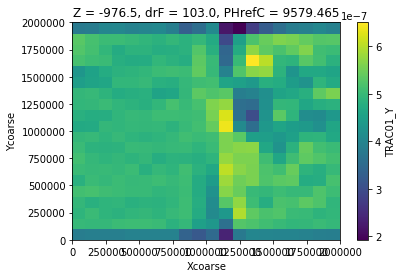

In [166]:
trac_grads['TRAC01_Y'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')

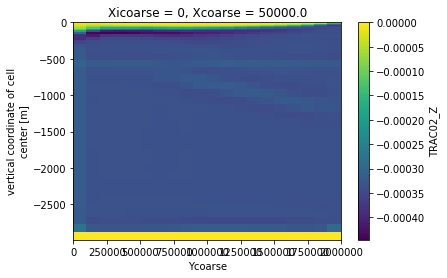

In [167]:
trac_grads['TRAC02_Z'].sel(Xicoarse=0, method='nearest').plot(x='Ycoarse', y='Z')

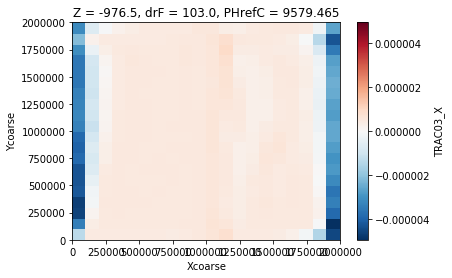

In [157]:
trac_grads['TRAC03_X'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')

In [169]:
# Instead of keeping different tracer fluxes in dicitionaries, 
# we would like to put them into an xarray. This will help vectorize calculations
# and also easy in plotting. 

# Put fluxes into xarrays
# U'C'
testxr1 = mean_flux_stxav['UTRAC01']
testxr1['tracer_num'] = 1

UpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = mean_flux_stxav['U'+i]
    temp['tracer_num'] = n 
    n=n+1
    
    UpCp = xr.concat([UpCp, temp], dim='tracer_num')

# V'C'
testxr1 = mean_flux_stxav['VTRAC01']
testxr1['tracer_num'] = 1

VpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = mean_flux_stxav['V'+i]
    temp['tracer_num'] = n 
    n=n+1
    
    VpCp = xr.concat([VpCp, temp], dim='tracer_num')
    
# W'C'
testxr1 = mean_flux_stxav['WTRAC01']
testxr1['tracer_num'] = 1

WpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = mean_flux_stxav['W'+i]
    temp['tracer_num'] = n 
    n=n+1
    
    WpCp = xr.concat([WpCp, temp], dim='tracer_num')    
    
# Put tracer gradients into xarrays
# dCdx
testxr1 = trac_grads['TRAC01_X']
testxr1['tracer_num'] = 1

dCdx = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = trac_grads[i+'_X']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdx = xr.concat([dCdx, temp], dim='tracer_num')
    
# dCdy
testxr1 = trac_grads['TRAC01_Y']
testxr1['tracer_num'] = 1

dCdy = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = trac_grads[i+'_Y']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdy = xr.concat([dCdy, temp], dim='tracer_num')   
    
# dCdz
testxr1 = trac_grads['TRAC01_Z']
testxr1['tracer_num'] = 1

dCdz = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = trac_grads[i+'_Z']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdz = xr.concat([dCdz, temp], dim='tracer_num')       

In [172]:
# Function to calculate the diffusivity tensor 

def calc_tensor(uc,vc,wc, cx,cy,cz):
    Aflux = np.array([uc, vc, wc])
    Agrad = np.array([cx, cy, cz])


    if ~(np.isnan(Agrad).any() | np.isnan(Aflux).any()):
        return -(Aflux.dot(pinv(Agrad)))
    else:
        return np.nan*(Aflux.dot(Agrad.T))

In [173]:
# Do some chunking so that dask might be able to speed up calculations 
# DB says this is useless....

UpCp = UpCp.chunk({'Z':2,'XC':20})
VpCp = VpCp.chunk({'Z':2,'XC':20})
WpCp = WpCp.chunk({'Z':2,'XC':20})

dCdx = dCdx.chunk({'Z':2,'XC':20})
dCdy = dCdy.chunk({'Z':2,'XC':20})
dCdz = dCdz.chunk({'Z':2,'XC':20})

ValueError: some chunks keys are not dimensions on this object: ['XC']

In [178]:
%%time # timer!  like tic <..> tock

# Save flux variables into netcdf files 
# here we reload them to memory to check if it helps speed up 
# (based on a hint in xarray manual)
UpCp.to_netcdf('UpCp_sav.nc')
UpCp = xr.open_dataarray('UpCp_sav.nc', chunks={'Z':2})

VpCp.to_netcdf('VpCp_sav.nc')
VpCp = xr.open_dataarray('VpCp_sav.nc', chunks={'Z':2})

WpCp.to_netcdf('WpCp_sav.nc')
WpCp = xr.open_dataarray('WpCp_sav.nc', chunks={'Z':2})

dCdx.to_netcdf('dcdx_sav.nc')
dCdx = xr.open_dataarray('dcdx_sav.nc', chunks={'Z':2})

dCdy.to_netcdf('dcdy_sav.nc')
dCdy = xr.open_dataarray('dcdy_sav.nc', chunks={'Z':2})

dCdz.to_netcdf('dcdz_sav.nc')
dCdz = xr.open_dataarray('dcdz_sav.nc', chunks={'Z':2})

PermissionError: [Errno 13] Permission denied: b'/home/dbalwada/3D_tracer_inversion/VpCp_sav.nc'

In [180]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)


Ktensor = xr.apply_ufunc(calc_tensor, 
                       UpCp,
                       VpCp,
                       WpCp,
                       dCdx,
                       dCdy,
                       dCdz,
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor.load() # need to load because we will take transpose and add 

CPU times: user 10.8 s, sys: 4.02 s, total: 14.8 s
Wall time: 10.7 s


Redo some calculations with only few tracers, and check how well the tracer left out is captured by the diffusivity tensor.

In [475]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)


Ktensor9 = xr.apply_ufunc(calc_tensor, 
                       UpCp.isel(tracer_num=slice(0,9)),
                       VpCp.isel(tracer_num=slice(0,9)),
                       WpCp.isel(tracer_num=slice(0,9)),
                       dCdx.isel(tracer_num=slice(0,9)),
                       dCdy.isel(tracer_num=slice(0,9)),
                       dCdz.isel(tracer_num=slice(0,9)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor9.load() # need to load because we will take transpose and add 

CPU times: user 10.5 s, sys: 4.08 s, total: 14.6 s
Wall time: 10.3 s


In [597]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)


Ktensor_nolin = xr.apply_ufunc(calc_tensor, 
                       UpCp.isel(tracer_num=slice(4,10)),
                       VpCp.isel(tracer_num=slice(4,10)),
                       WpCp.isel(tracer_num=slice(4,10)),
                       dCdx.isel(tracer_num=slice(4,10)),
                       dCdy.isel(tracer_num=slice(4,10)),
                       dCdz.isel(tracer_num=slice(4,10)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_nolin.load() # need to load because we will take transpose and add 

CPU times: user 3.92 s, sys: 72.5 ms, total: 4 s
Wall time: 4.37 s


# Errors : How much of the flux signal is captured by the diffusivity tensor?

In [207]:
# Ktensor is R 

recUflux = Ktensor.sel(i=0, j=0)*dCdx + Ktensor.sel(i=0, j=1)*dCdy + Ktensor.sel(i=0, j=2)*dCdz
recVflux = Ktensor.sel(i=1, j=0)*dCdx + Ktensor.sel(i=1, j=1)*dCdy + Ktensor.sel(i=1, j=2)*dCdz
recWflux = Ktensor.sel(i=2, j=0)*dCdx + Ktensor.sel(i=2, j=1)*dCdy + Ktensor.sel(i=2, j=2)*dCdz

errU = np.abs(UpCp + recUflux)/np.abs(UpCp)
errV = np.abs(VpCp + recVflux)/np.abs(VpCp)
errW = np.abs(WpCp + recWflux)/np.abs(WpCp)

In [476]:
# Ktensor is R 

recUflux9 = Ktensor9.sel(i=0, j=0)*dCdx + Ktensor9.sel(i=0, j=1)*dCdy + Ktensor9.sel(i=0, j=2)*dCdz
recVflux9 = Ktensor9.sel(i=1, j=0)*dCdx + Ktensor9.sel(i=1, j=1)*dCdy + Ktensor9.sel(i=1, j=2)*dCdz
recWflux9 = Ktensor9.sel(i=2, j=0)*dCdx + Ktensor9.sel(i=2, j=1)*dCdy + Ktensor9.sel(i=2, j=2)*dCdz

errU9 = np.abs(UpCp + recUflux9)/np.abs(UpCp)
errV9 = np.abs(VpCp + recVflux9)/np.abs(VpCp)
errW9 = np.abs(WpCp + recWflux9)/np.abs(WpCp)

In [598]:
# Ktensor is R 

recUflux_nolin = Ktensor_nolin.sel(i=0, j=0)*dCdx + Ktensor_nolin.sel(i=0, j=1)*dCdy + Ktensor_nolin.sel(i=0, j=2)*dCdz
recVflux_nolin = Ktensor_nolin.sel(i=1, j=0)*dCdx + Ktensor_nolin.sel(i=1, j=1)*dCdy + Ktensor_nolin.sel(i=1, j=2)*dCdz
recWflux_nolin = Ktensor_nolin.sel(i=2, j=0)*dCdx + Ktensor_nolin.sel(i=2, j=1)*dCdy + Ktensor_nolin.sel(i=2, j=2)*dCdz

errU_nolin = np.abs(UpCp + recUflux_nolin)/np.abs(UpCp)
errV_nolin = np.abs(VpCp + recVflux_nolin)/np.abs(VpCp)
errW_nolin = np.abs(WpCp + recWflux_nolin)/np.abs(WpCp)

In [477]:
errU9.load()
errV9.load()
errW9.load()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask/local.py:253: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


<xarray.DataArray (tracer_num: 10, Xicoarse: 20, Yicoarse: 20, Z: 40)>
array([[[[ 9.158903, ...,  2.760018],
         ...,
         [ 0.174036, ...,  0.563987]],

        ...,

        [[ 9.448239, ...,  2.085086],
         ...,
         [ 0.524977, ..., 15.258044]]],


       ...,


       [[[ 1.841472, ...,  1.323864],
         ...,
         [ 6.250182, ...,  0.659173]],

        ...,

        [[ 4.023624, ...,  0.768725],
         ...,
         [32.941315, ...,  1.020777]]]], dtype=float32)
Coordinates:
  * Z           (Z) float32 -5.0 -15.0 -25.0 -36.0 ... -2727.5 -2830.5 -2933.5
    drF         (Z) float32 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0
    PHrefC      (Z) float32 49.05 147.15 245.25 ... 27767.205 28777.635
  * Yicoarse    (Yicoarse) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
  * Xicoarse    (Xicoarse) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
    Ycoarse     (Yicoarse) float32 50000.0 150000.0 ... 1850000.0 1950000.0
    Xcoarse     (Xicoa

In [599]:
errU_nolin.load()
errV_nolin.load()
errW_nolin.load()

<xarray.DataArray (tracer_num: 11, Xicoarse: 20, Yicoarse: 20, Z: 40)>
array([[[[10.093688, ...,  4.478878],
         ...,
         [ 1.189376, ..., 18.391434]],

        ...,

        [[11.505236, ...,  7.054906],
         ...,
         [ 1.114431, ..., 89.06637 ]]],


       ...,


       [[[ 6.398425, ...,  7.495178],
         ...,
         [62.95671 , ...,  9.087997]],

        ...,

        [[ 7.134669, ..., 11.367819],
         ...,
         [48.109867, ..., 49.676846]]]], dtype=float32)
Coordinates:
  * Z           (Z) float32 -5.0 -15.0 -25.0 -36.0 ... -2727.5 -2830.5 -2933.5
    drF         (Z) float32 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0
    PHrefC      (Z) float32 49.05 147.15 245.25 ... 27767.205 28777.635
  * Yicoarse    (Yicoarse) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
  * Xicoarse    (Xicoarse) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
    Ycoarse     (Yicoarse) float32 50000.0 150000.0 ... 1850000.0 1950000.0
    Xcoarse     (Xicoa

In [271]:
errU.load()
errV.load()
errW.load()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/dask/local.py:253: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


<xarray.DataArray (tracer_num: 10, Xicoarse: 20, Yicoarse: 20, Z: 40)>
array([[[[ 9.126194, ...,  2.754697],
         ...,
         [ 0.174114, ...,  0.686761]],

        ...,

        [[ 9.444053, ...,  2.085578],
         ...,
         [ 0.530611, ..., 15.251368]]],


       ...,


       [[[ 1.756759, ...,  1.323164],
         ...,
         [ 6.248734, ...,  0.647656]],

        ...,

        [[ 3.986487, ...,  0.768692],
         ...,
         [32.611908, ...,  1.02071 ]]]], dtype=float32)
Coordinates:
  * Z           (Z) float32 -5.0 -15.0 -25.0 -36.0 ... -2727.5 -2830.5 -2933.5
    drF         (Z) float32 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0
    PHrefC      (Z) float32 49.05 147.15 245.25 ... 27767.205 28777.635
  * Yicoarse    (Yicoarse) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
  * Xicoarse    (Xicoarse) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
    Ycoarse     (Yicoarse) float32 50000.0 150000.0 ... 1850000.0 1950000.0
    Xcoarse     (Xicoa

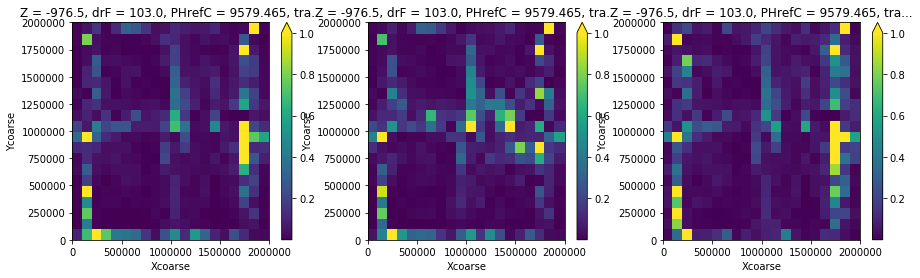

In [605]:
plt.figure(figsize=(15,4))
plt.subplot(131)
errU.isel(tracer_num=3).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

plt.subplot(132)
errU9.isel(tracer_num=3).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

plt.subplot(133)
errU_nolin.isel(tracer_num=3).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

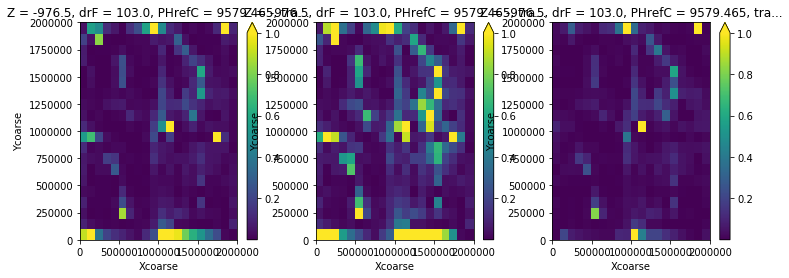

In [606]:
plt.figure(figsize=(12,4))
plt.subplot(131)
errU.isel(tracer_num=9).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

plt.subplot(132)
errU9.isel(tracer_num=9).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

plt.subplot(133)
errU_nolin.isel(tracer_num=9).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

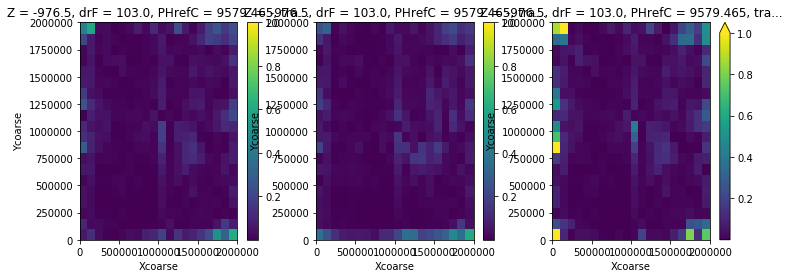

In [608]:
plt.figure(figsize=(12,4))
plt.subplot(131)
errV.isel(tracer_num=0).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

plt.subplot(132)
errV9.isel(tracer_num=0).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

plt.subplot(133)
errV_nolin.isel(tracer_num=0).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

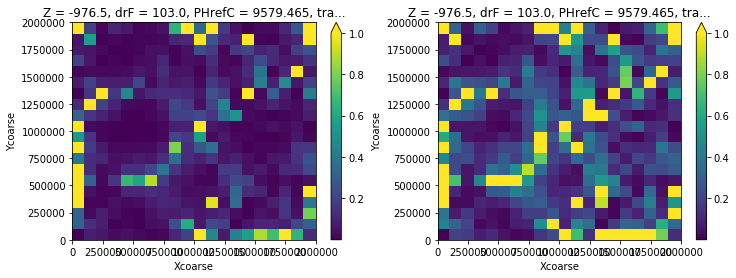

In [482]:
plt.figure(figsize=(12,4))
plt.subplot(121)
errW.isel(tracer_num=9).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

plt.subplot(122)
errW9.isel(tracer_num=9).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

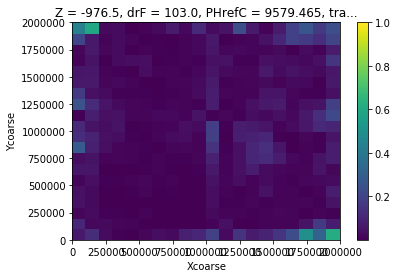

In [220]:
errV.sel(tracer_num=1).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

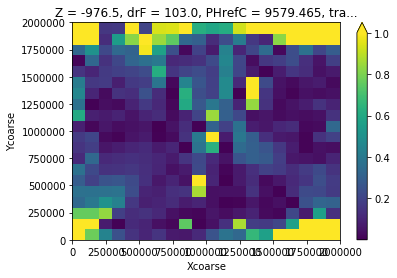

In [243]:
errW.sel(tracer_num=1).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

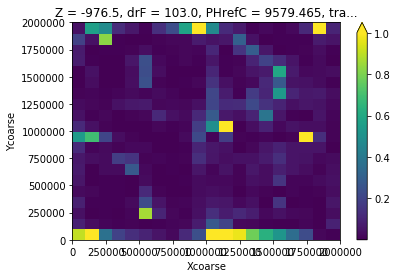

In [233]:
errU.sel(tracer_num=10).sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse',vmax=1)

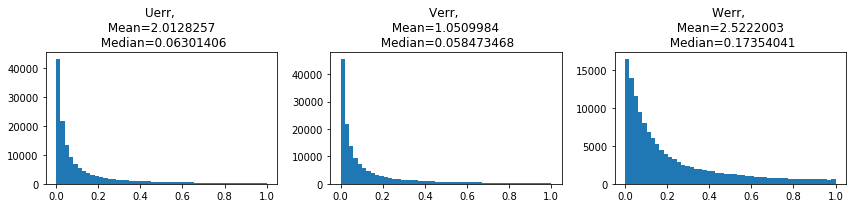

In [290]:
#  all the errors

plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errU.plot.hist(bins=bins)
m1 = errU.mean(['Xicoarse','Yicoarse','Z','tracer_num']).values
m2 = errU.median(['Xicoarse','Yicoarse','Z','tracer_num']).values

plt.title('Uerr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errV.plot.hist(bins=bins)
m1 = errV.mean(['Xicoarse','Yicoarse','Z','tracer_num']).values
m2 = errV.median(['Xicoarse','Yicoarse','Z','tracer_num']).values

plt.title('Verr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errW.plot.hist(bins=bins)
m1 = errW.mean(['Xicoarse','Yicoarse','Z','tracer_num']).values
m2 = errW.median(['Xicoarse','Yicoarse','Z','tracer_num']).values

plt.title('Werr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.tight_layout()

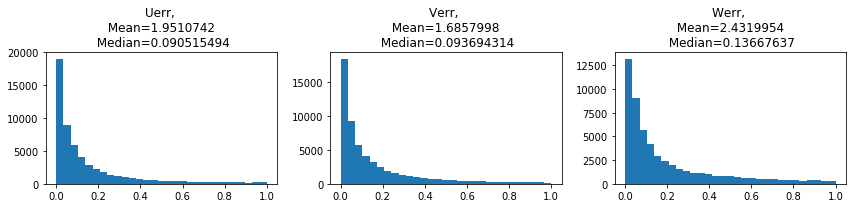

In [559]:
#  all the errors
bins = np.linspace(0,1,30)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errU.sel(Z=slice(0,-500)).plot.hist(bins=bins)
m1 = errU.sel(Z=slice(0,-500)).mean(['Xicoarse','Yicoarse','Z','tracer_num']).values
m2 = errU.sel(Z=slice(0,-500)).median(['Xicoarse','Yicoarse','Z','tracer_num']).values

plt.title('Uerr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errV.sel(Z=slice(0,-500)).plot.hist(bins=bins)
m1 = errV.sel(Z=slice(0,-500)).mean(['Xicoarse','Yicoarse','Z','tracer_num']).values
m2 = errV.sel(Z=slice(0,-500)).median(['Xicoarse','Yicoarse','Z','tracer_num']).values

plt.title('Verr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errW.sel(Z=slice(0,-500)).plot.hist(bins=bins)
m1 = errW.sel(Z=slice(0,-500)).mean(['Xicoarse','Yicoarse','Z','tracer_num']).values
m2 = errW.sel(Z=slice(0,-500)).median(['Xicoarse','Yicoarse','Z','tracer_num']).values

plt.title('Werr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.tight_layout()

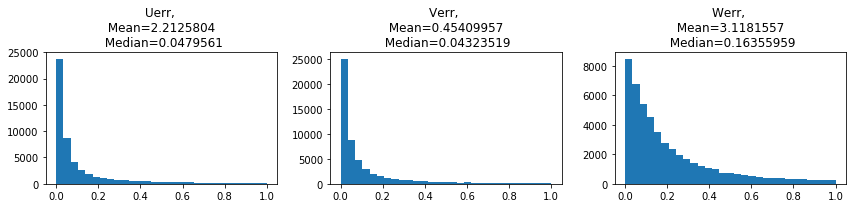

In [560]:
#  all the errors
bins = np.linspace(0,1,30)

plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errU.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)
m1 = errU.sel(Z=slice(-500,-2000)).mean(['Xicoarse','Yicoarse','Z','tracer_num']).values
m2 = errU.sel(Z=slice(-500,-2000)).median(['Xicoarse','Yicoarse','Z','tracer_num']).values

plt.title('Uerr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errV.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)
m1 = errV.sel(Z=slice(-500,-2000)).mean(['Xicoarse','Yicoarse','Z','tracer_num']).values
m2 = errV.sel(Z=slice(-500,-2000)).median(['Xicoarse','Yicoarse','Z','tracer_num']).values

plt.title('Verr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errW.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)
m1 = errW.sel(Z=slice(-500,-2000)).mean(['Xicoarse','Yicoarse','Z','tracer_num']).values
m2 = errW.sel(Z=slice(-500,-2000)).median(['Xicoarse','Yicoarse','Z','tracer_num']).values

plt.title('Werr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.tight_layout()

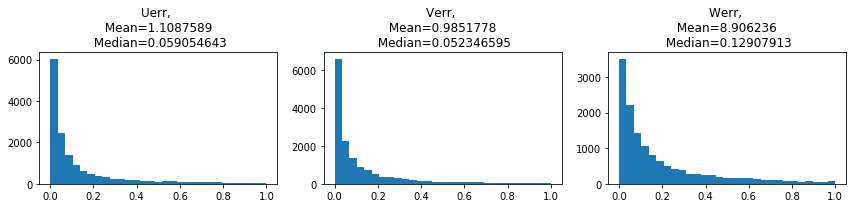

In [489]:
#  all the errors
bins = np.linspace(0,1,30)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errU.isel(tracer_num=9).plot.hist(bins=bins)
m1 = errU.isel(tracer_num=9).mean(['Xicoarse','Yicoarse','Z']).values
m2 = errU.isel(tracer_num=9).median(['Xicoarse','Yicoarse','Z']).values

plt.title('Uerr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errV.isel(tracer_num=9).plot.hist(bins=bins)
m1 = errV.isel(tracer_num=9).mean(['Xicoarse','Yicoarse','Z']).values
m2 = errV.isel(tracer_num=9).median(['Xicoarse','Yicoarse','Z']).values

plt.title('Verr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errW.isel(tracer_num=9).plot.hist(bins=bins)
m1 = errW.isel(tracer_num=9).mean(['Xicoarse','Yicoarse','Z']).values
m2 = errW.isel(tracer_num=9).median(['Xicoarse','Yicoarse','Z']).values

plt.title('Werr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.tight_layout()

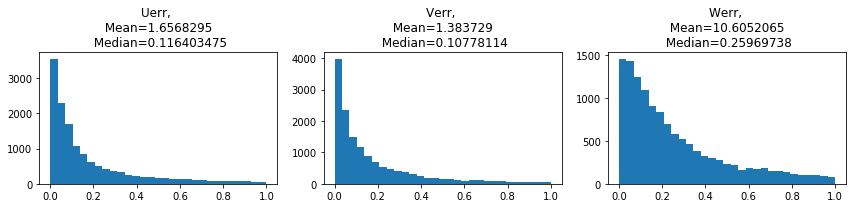

In [488]:
#  all the errors
bins = np.linspace(0,1,30)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errU9.isel(tracer_num=9).plot.hist(bins=bins)
m1 = errU9.isel(tracer_num=9).mean(['Xicoarse','Yicoarse','Z']).values
m2 = errU9.isel(tracer_num=9).median(['Xicoarse','Yicoarse','Z']).values

plt.title('Uerr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errV9.isel(tracer_num=9).plot.hist(bins=bins)
m1 = errV9.isel(tracer_num=9).mean(['Xicoarse','Yicoarse','Z']).values
m2 = errV9.isel(tracer_num=9).median(['Xicoarse','Yicoarse','Z']).values

plt.title('Verr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errW9.isel(tracer_num=9).plot.hist(bins=bins)
m1 = errW9.isel(tracer_num=9).mean(['Xicoarse','Yicoarse','Z']).values
m2 = errW9.isel(tracer_num=9).median(['Xicoarse','Yicoarse','Z']).values

plt.title('Werr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.tight_layout()

# How well are b fluxes reproduced.

In [ ]:
# calculate averaged b, and gradients. 

In [291]:
Tmean = Model_tav.Ttave
Tmean.coords['Yicoarse'] = ('YC', Yicoarse)
Tmean.coords['Xicoarse'] = ('XC', Xicoarse)
Tmeansav = Tmean.groupby('Yicoarse').mean('YC')
Tmeansav = Tmeansav.groupby('Xicoarse').mean('XC')
Tmeansav.coords['Ycoarse'] = ('Yicoarse', Tmean.YC.groupby('Yicoarse').mean('YC'))
Tmeansav.coords['Xcoarse'] = ('Xicoarse', Tmean.XC.groupby('Xicoarse').mean('XC'))

In [389]:
Tfinegrads = xr.Dataset()
Tfinegrads['T_Z']= -grid.diff(grid.interp(Tmean, 'Z', boundary='extend'),
                                    'Z', boundary='extend')/Tmean.drF
Tfinegrads['T_Y'] = grid.diff(grid.interp(Tmean, 'Y', boundary='extend'),
                             'Y', boundary='extend')/ Model_tav.dyC[0,0]

Tfinegrads['T_X'] = grid.diff(grid.interp(Tmean, 'X'),
                             'X')/ Model_tav.dxC[0,0]

In [292]:
# gradients on coarse grid
Tgrads = xr.Dataset()

# Z grads
Tgrads['T_Z'] = -grid.diff(grid.interp(Tmeansav, 'Z', boundary='extend'),
                                    'Z', boundary='extend')/Tmeansav.drF

In [293]:
Tstag = Tmean

In [ ]:
Tstag.coords['Yicstag'] = ('YC', Yicstag)
Tstag.coords['Xicstag'] = ('XC', Xicstag)

In [312]:
# Y grads 
Tstag_sav = Tstag.groupby('Yicstag').mean('YC')
Tstag_sav = Tstag_sav.groupby('Xicoarse').mean('XC')

temp = Tstag_sav.diff('Yicstag')/Lcoarse
    
temp = xr.DataArray(temp.data, dims=['Z', 'Yicoarse', 'Xicoarse'],
                    coords=[ Tgrads.Z, Tgrads.Yicoarse,Tgrads.Xicoarse])
    
Tgrads['T_Y'] = temp

In [319]:
# X grads 
# only averate in X direction on center points
Tstag_sav = Tstag.groupby('Yicoarse').mean('YC')
Tstag_sav = Tstag_sav.groupby('Xicstag').mean('XC')


temp = (Tstag_sav.data - np.roll(Tstag_sav.data,1,axis=2))/Lcoarse
temp = xr.DataArray(temp.data, dims=['Z', 'Yicoarse', 'Xicoarse'],
                    coords=[trac_grads.Z ,trac_grads.Yicoarse, trac_grads.Xicoarse])
        
Tgrads['T_X'] = temp

In [524]:
Tgrads.coords['Ycoarse'] = ('Yicoarse', Tmean.YC.groupby('Yicoarse').mean('YC'))
Tgrads.coords['Xcoarse'] = ('Xicoarse', Tmean.XC.groupby('Xicoarse').mean('XC'))

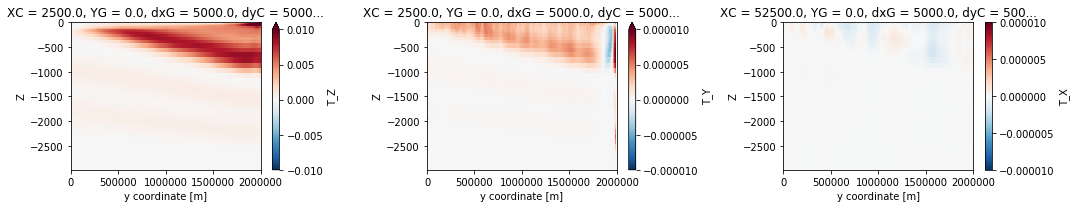

In [496]:
plt.figure(figsize=(15,3))
plt.subplot(131)
Tfinegrads['T_Z'].isel(XC=0).plot(vmin=-0.01)
plt.ylabel('Z')

plt.subplot(132)
Tfinegrads['T_Y'].isel(XC=0).plot(vmin=-1e-5)
plt.ylabel('Z')

plt.subplot(133)
Tfinegrads['T_X'].isel(XC=10).plot(vmin=-1e-5)
plt.ylabel('Z')

plt.tight_layout()

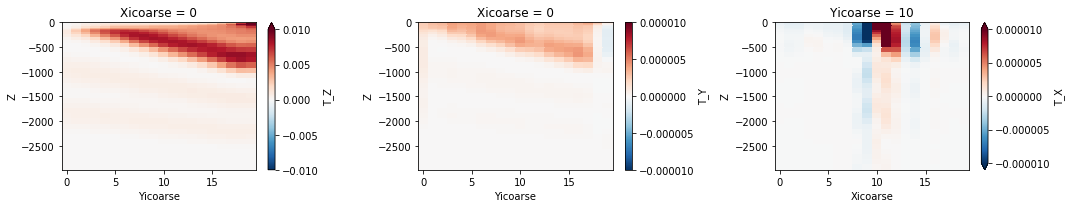

In [495]:
plt.figure(figsize=(15,3))
plt.subplot(131)
Tgrads['T_Z'].isel(Xicoarse=0).plot(vmin=-0.01)
plt.ylabel('Z')

plt.subplot(132)
Tgrads['T_Y'].isel(Xicoarse=0).plot(vmin=-1e-5)
plt.ylabel('Z')

plt.subplot(133)
Tgrads['T_X'].isel(Yicoarse=10).plot(vmin=-1e-5)
plt.ylabel('Z')

plt.tight_layout()

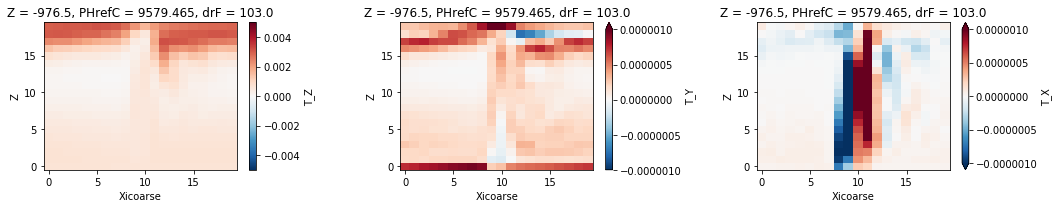

In [404]:
plt.figure(figsize=(15,3))
plt.subplot(131)
Tgrads['T_Z'].sel(Z=-1000, method='nearest').plot(vmin=-0.005)
plt.ylabel('Z')

plt.subplot(132)
Tgrads['T_Y'].sel(Z=-1000, method='nearest').plot(vmin=-0.1e-5)
plt.ylabel('Z')

plt.subplot(133)
Tgrads['T_X'].sel(Z=-1000, method='nearest').plot(vmin=-0.1e-5)
plt.ylabel('Z')

plt.tight_layout()

In [328]:
Tflux_tav['UTtave']= grid.interp(Tflux_tav.UTtave, 'X')
Tflux_tav['VTtave'] = grid.interp(Tflux_tav.VTtave, 'Y', boundary='extend')
Tflux_tav['WTtave'] = grid.interp(Tflux_tav.WTtave, 'Z', boundary='extend')

In [427]:
Tflux_tav['UpTp'] = Tflux_tav['UTtave'] - Umean*Tmean
Tflux_tav['VpTp'] = Tflux_tav['VTtave'] - Vmean*Tmean
Tflux_tav['WpTp'] = Tflux_tav['WTtave'] - Wmean*Tmean

In [428]:
Tflux_tav

<xarray.Dataset>
Dimensions:   (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40)
Coordinates:
  * XC        (XC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * YC        (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG        (XG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * YG        (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
    dxC       (YC, XG) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    dyG       (YC, XG) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    dxG       (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    dyC       (YG, XC) >f4

In [490]:
Tflux_tav.coords['Yicoarse'] = ('YC', Yicoarse)
Tflux_tav.coords['Xicoarse'] = ('XC', Xicoarse)
Tflux_xstav = Tflux_tav.groupby('Yicoarse').mean('YC')
Tflux_xstav = Tflux_xstav.groupby('Xicoarse').mean('XC')
Tflux_xstav.coords['Ycoarse'] = ('Yicoarse', Tflux_tav.YC.groupby('Yicoarse').mean('YC'))
Tflux_xstav.coords['Xcoarse'] = ('Xicoarse', Tflux_tav.XC.groupby('Xicoarse').mean('XC'))

In [491]:
# flux datasets 
Tflux_stxav = xr.Dataset()

Tflux_stxav['UpTp'] = Tflux_xstav['UTtave'] - Umeansav * Tmeansav 
Tflux_stxav['VpTp'] = Tflux_xstav['VTtave'] - Vmeansav * Tmeansav
Tflux_stxav['WpTp'] = Tflux_xstav['WTtave'] - Wmeansav * Tmeansav

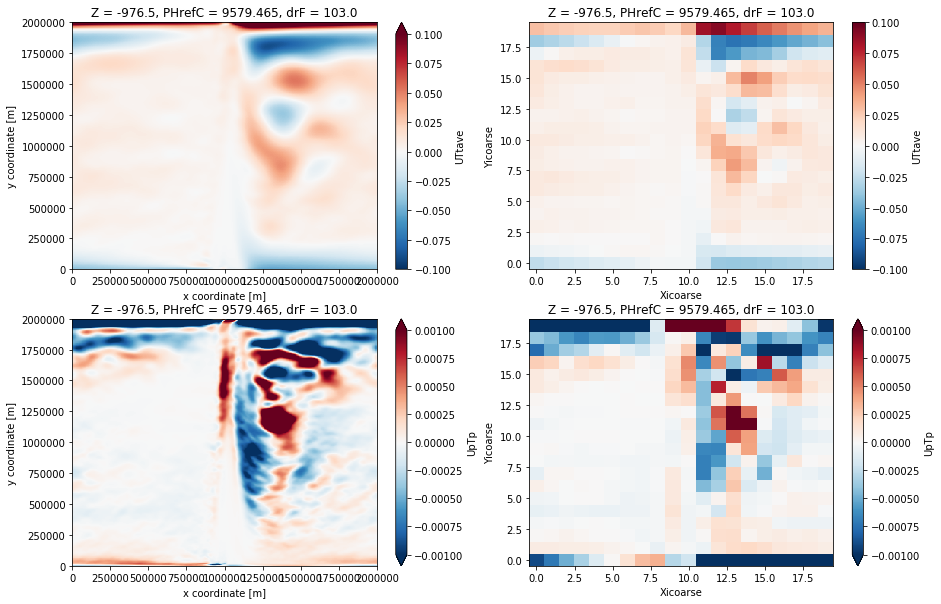

In [500]:
plt.figure(figsize=(15,10))

plt.subplot(221)
Tflux_tav['UTtave'].sel(Z=-1000, method='nearest').plot(vmin=-0.1)

plt.subplot(222)
Tflux_xstav['UTtave'].sel(Z=-1000, method='nearest').plot(x='Xicoarse',y='Yicoarse', vmin=-0.1)

plt.subplot(223)
Tflux_tav['UpTp'].sel(Z=-1000, method='nearest').plot( vmin=-0.001)

plt.subplot(224)
Tflux_stxav['UpTp'].sel(Z=-1000, method='nearest').plot(x='Xicoarse',y='Yicoarse', vmin=-0.001)

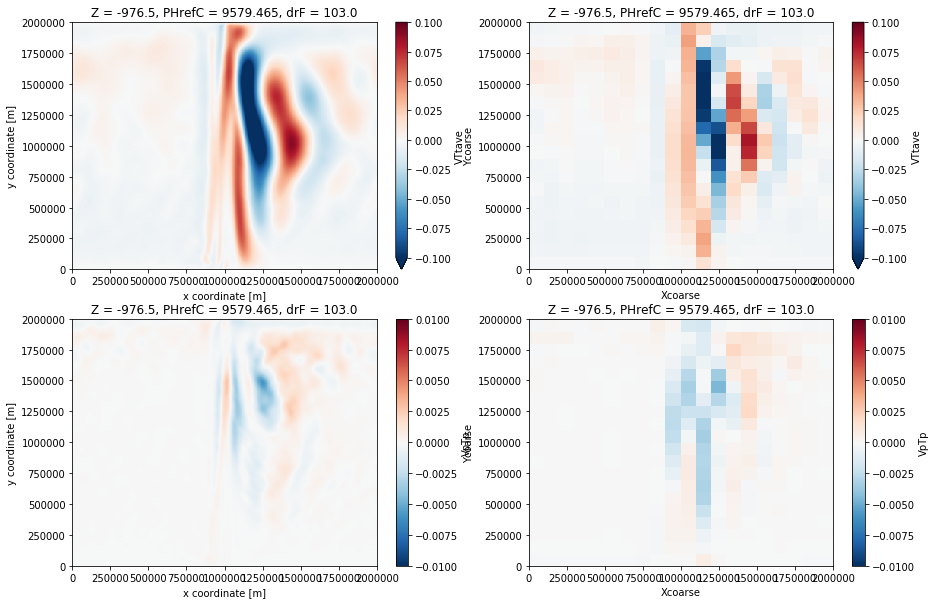

In [493]:
plt.figure(figsize=(15,10))

plt.subplot(221)
Tflux_tav['VTtave'].sel(Z=-1000, method='nearest').plot(vmin=-0.1)

plt.subplot(222)
Tflux_xstav['VTtave'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse', vmin=-0.1)

plt.subplot(223)
Tflux_tav['VpTp'].sel(Z=-1000, method='nearest').plot(vmin=-0.01)

plt.subplot(224)
Tflux_stxav['VpTp'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse', vmin=-0.01)

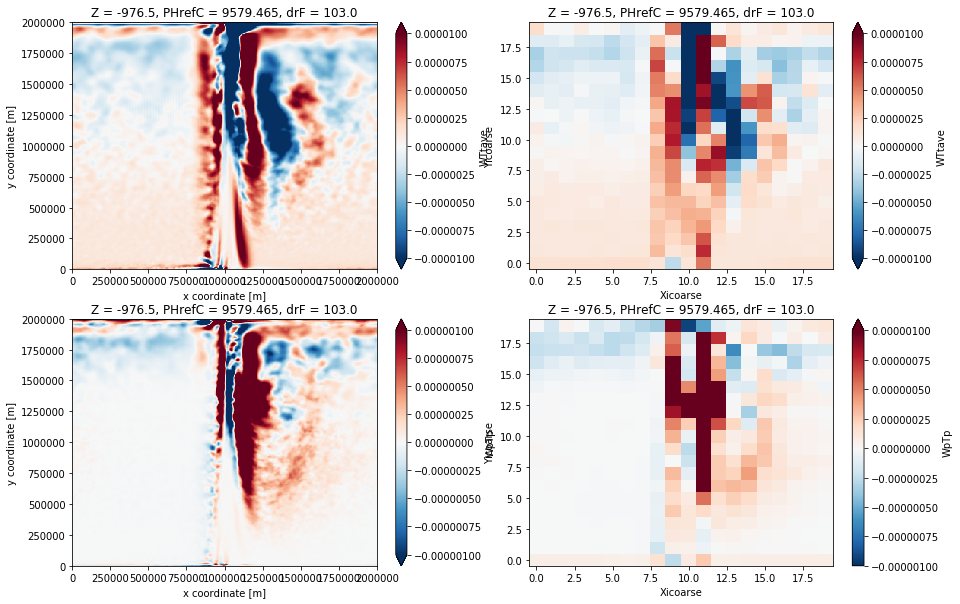

In [494]:
plt.figure(figsize=(15,10))

plt.subplot(221)
Tflux_tav['WTtave'].sel(Z=-1000, method='nearest').plot(vmin=-1e-5)

plt.subplot(222)
Tflux_xstav['WTtave'].sel(Z=-1000, method='nearest').plot(x='Xicoarse',y='Yicoarse', vmin=-1e-5)

plt.subplot(223)
Tflux_tav['WpTp'].sel(Z=-1000, method='nearest').plot(vmin=-0.1e-5)

plt.subplot(224)
Tflux_stxav['WpTp'].sel(Z=-1000, method='nearest').plot(x='Xicoarse',y='Yicoarse', vmin=-0.1e-5)

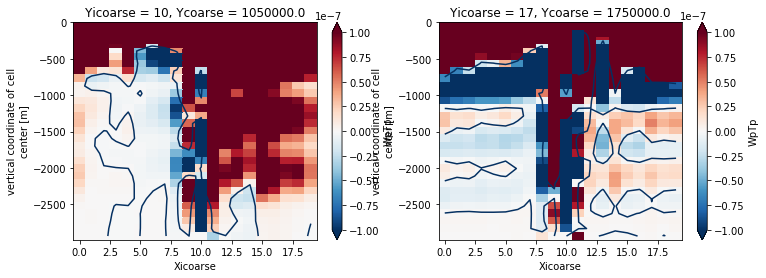

In [442]:
plt.figure(figsize=(12,4))
plt.subplot(121)
Tflux_stxav['WpTp'].isel(Yicoarse = 10).plot(x='Xicoarse',y='Z', vmin=-0.1e-6)
Tflux_stxav['WpTp'].isel(Yicoarse = 10).plot.contour(x='Xicoarse',y='Z', levels=[0])

plt.subplot(122)
Tflux_stxav['WpTp'].isel(Yicoarse = 17).plot(x='Xicoarse',y='Z', vmin=-0.1e-6)
Tflux_stxav['WpTp'].isel(Yicoarse = 17).plot.contour(x='Xicoarse',y='Z', levels=[0])

In [1]:
plt.figure(figsize=(12,4))
plt.subplot(121)
Tflux_xstav['VpTp'].isel(Yicoarse = 10).plot(x='Xicoarse',y='Z', vmin=-0.1e-2)
Tflux_xstav['VpTp'].isel(Yicoarse = 10).plot.contour(x='Xicoarse',y='Z', levels=[0])

plt.subplot(122)
Tflux_stxav['VpTp'].isel(Yicoarse = 17).plot(x='Xicoarse',y='Z', vmin=-0.1e-2)
Tflux_stxav['VpTp'].isel(Yicoarse = 17).plot.contour(x='Xicoarse',y='Z', levels=[0])

NameError: name 'plt' is not defined

In [561]:
# Ktensor is R 

recUB = Ktensor.sel(i=0, j=0)*Tgrads.T_X + Ktensor.sel(i=0, j=1)*Tgrads.T_Y + Ktensor.sel(i=0, j=2)*Tgrads.T_Z
recVB = Ktensor.sel(i=1, j=0)*Tgrads.T_X + Ktensor.sel(i=1, j=1)*Tgrads.T_Y + Ktensor.sel(i=1, j=2)*Tgrads.T_Z
recWB = Ktensor.sel(i=2, j=0)*Tgrads.T_X + Ktensor.sel(i=2, j=1)*Tgrads.T_Y + Ktensor.sel(i=2, j=2)*Tgrads.T_Z

errUB = np.abs(Tflux_stxav.UpTp + recUB)/np.abs(Tflux_stxav.UpTp)
errVB = np.abs(Tflux_stxav.VpTp + recVB)/np.abs(Tflux_stxav.VpTp)
errWB = np.abs(Tflux_stxav.WpTp + recWB)/np.abs(Tflux_stxav.WpTp)

In [562]:
recUB_skew = AT.sel(i=0, j=0)*Tgrads.T_X + AT.sel(i=0, j=1)*Tgrads.T_Y + AT.sel(i=0, j=2)*Tgrads.T_Z
recVB_skew = AT.sel(i=1, j=0)*Tgrads.T_X + AT.sel(i=1, j=1)*Tgrads.T_Y + AT.sel(i=1, j=2)*Tgrads.T_Z
recWB_skew = AT.sel(i=2, j=0)*Tgrads.T_X + AT.sel(i=2, j=1)*Tgrads.T_Y + AT.sel(i=2, j=2)*Tgrads.T_Z

errUB_skew = np.abs(Tflux_stxav.UpTp + recUB_skew)/np.abs(Tflux_stxav.UpTp)
errVB_skew = np.abs(Tflux_stxav.VpTp + recVB_skew)/np.abs(Tflux_stxav.VpTp)
errWB_skew = np.abs(Tflux_stxav.WpTp + recWB_skew)/np.abs(Tflux_stxav.WpTp)

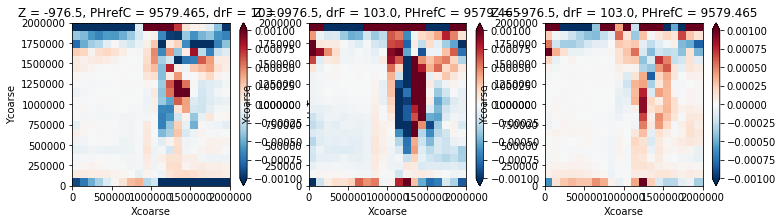

In [506]:
plt.figure(figsize=(12,3))

plt.subplot(131)
Tflux_stxav['UpTp'].sel(Z=-1000,method='nearest').plot(x='Xcoarse',y='Ycoarse', vmin=-0.001)

plt.subplot(132)
(-recUB).sel(Z=-1000,method='nearest').plot(x='Xcoarse',y='Ycoarse', vmin=-0.001)

plt.subplot(133)
(-recUB_skew).sel(Z=-1000,method='nearest').plot(x='Xcoarse',y='Ycoarse', vmin=-0.001)

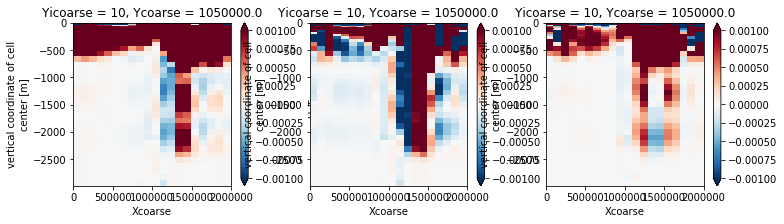

In [563]:
plt.figure(figsize=(12,3))

plt.subplot(131)
Tflux_stxav['UpTp'].isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

plt.subplot(132)
(-recUB).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

plt.subplot(133)
(-recUB_skew).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

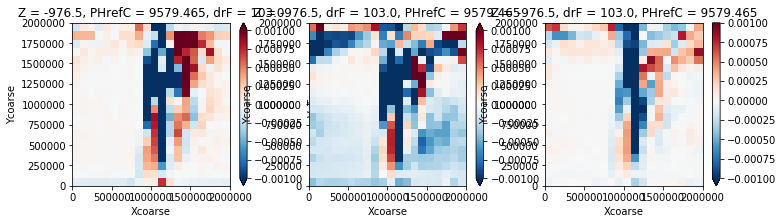

In [564]:
plt.figure(figsize=(12,3))

plt.subplot(131)
Tflux_stxav['VpTp'].sel(Z=-1000,method='nearest').plot(x='Xcoarse',y='Ycoarse', vmin=-0.001)

plt.subplot(132)
(-recVB).sel(Z=-1000,method='nearest').plot(x='Xcoarse',y='Ycoarse', vmin=-0.001)

plt.subplot(133)
(-recVB_skew).sel(Z=-1000,method='nearest').plot(x='Xcoarse',y='Ycoarse', vmin=-0.001)

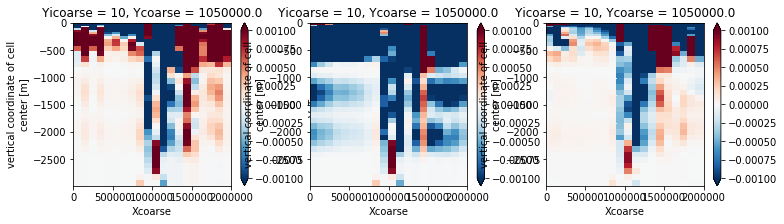

In [565]:
plt.figure(figsize=(12,3))

plt.subplot(131)
Tflux_stxav['VpTp'].isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

plt.subplot(132)
(-recVB).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

plt.subplot(133)
(-recVB_skew).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

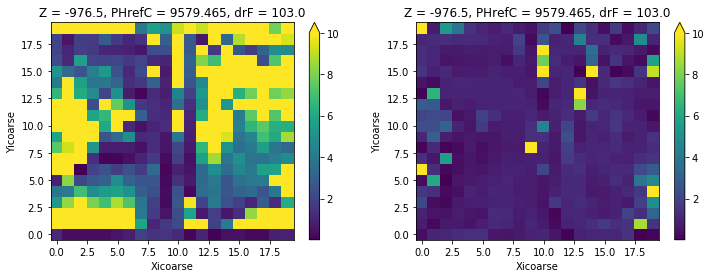

In [507]:
plt.figure(figsize=(12,4))
plt.subplot(121)
errWB.sel(Z=-1000, method='nearest').plot(x='Xicoarse', y='Yicoarse',vmax=10)

plt.subplot(122)
errWB_skew.sel(Z=-1000, method='nearest').plot(x='Xicoarse', y='Yicoarse',vmax=10)

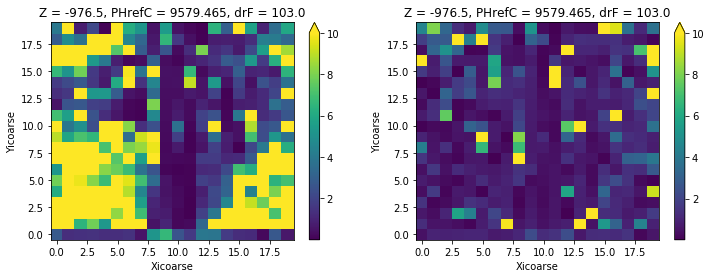

In [512]:
plt.figure(figsize=(12,4))
plt.subplot(121)
errVB.sel(Z=-1000, method='nearest').plot(x='Xicoarse', y='Yicoarse',vmax=10)

plt.subplot(122)
errVB_skew.sel(Z=-1000, method='nearest').plot(x='Xicoarse', y='Yicoarse',vmax=10)

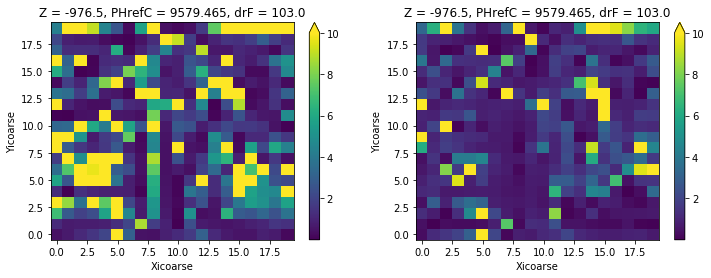

In [511]:
plt.figure(figsize=(12,4))
plt.subplot(121)
errUB.sel(Z=-1000, method='nearest').plot(x='Xicoarse', y='Yicoarse',vmax=10)

plt.subplot(122)
errUB_skew.sel(Z=-1000, method='nearest').plot(x='Xicoarse', y='Yicoarse',vmax=10)

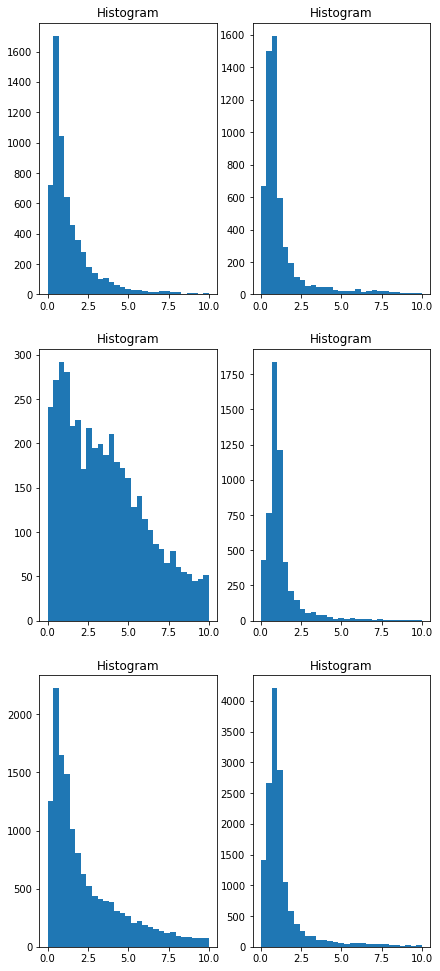

In [566]:
bins = np.linspace(0,10,30)

plt.figure(figsize=(7,17))
plt.subplot(321)
[_,_,_] = errWB.sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(322)
[_,_,_] = errWB_skew.sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(323)
[_,_,_] = errWB.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(324)
[_,_,_] = errWB_skew.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(325)
[_,_,_] = errWB.plot.hist(bins=bins)

plt.subplot(326)
[_,_,_] = errWB_skew.plot.hist(bins=bins)


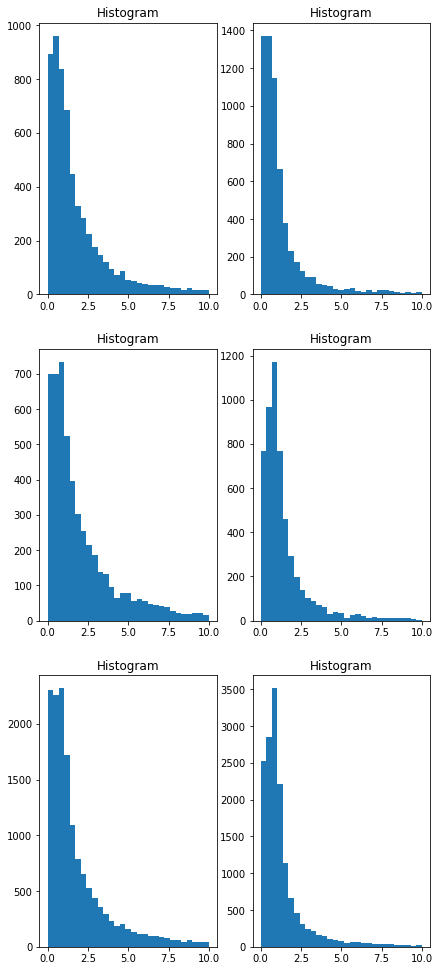

In [567]:
bins = np.linspace(0,10,30)

plt.figure(figsize=(7,17))
plt.subplot(321)
[_,_,_] = errUB.sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(322)
[_,_,_] = errUB_skew.sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(323)
[_,_,_] = errUB.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(324)
[_,_,_] = errUB_skew.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(325)
[_,_,_] = errUB.plot.hist(bins=bins)

plt.subplot(326)
[_,_,_] = errUB_skew.plot.hist(bins=bins)

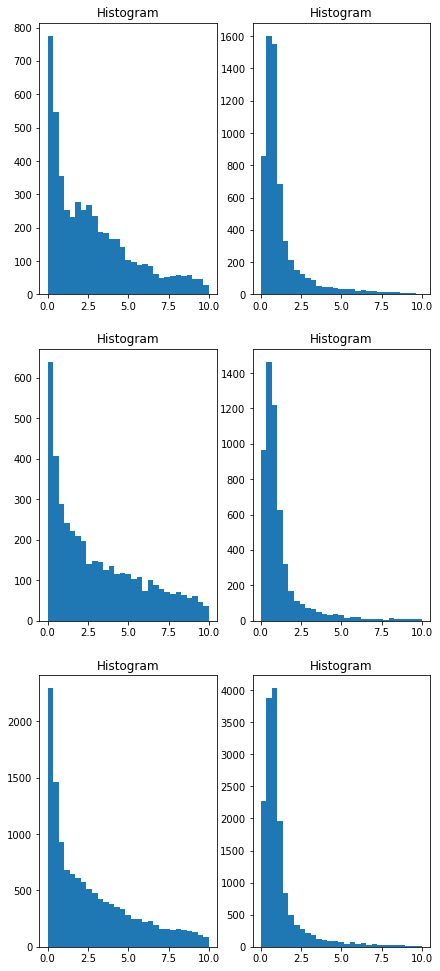

In [568]:
bins = np.linspace(0,10,30)

plt.figure(figsize=(7,17))
plt.subplot(321)
[_,_,_] = errVB.sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(322)
[_,_,_] = errVB_skew.sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(323)
[_,_,_] = errVB.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(324)
[_,_,_] = errVB_skew.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(325)
[_,_,_] = errVB.plot.hist(bins=bins)

plt.subplot(326)
[_,_,_] = errVB_skew.plot.hist(bins=bins)

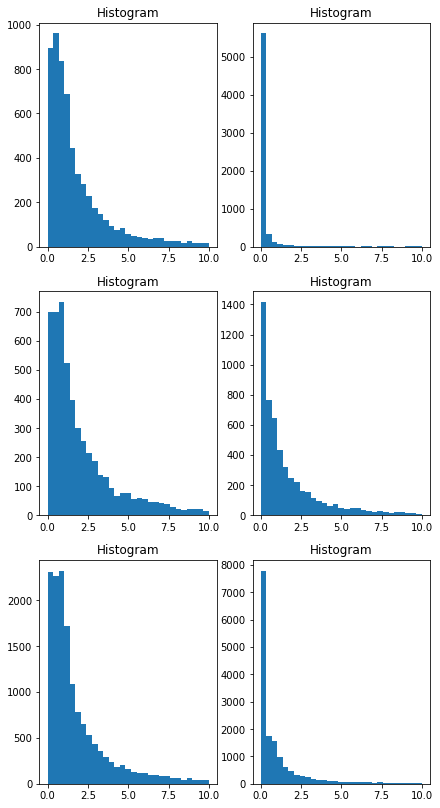

In [571]:
bins = np.linspace(0,10,30)

plt.figure(figsize=(7,14))
plt.subplot(321)
[_,_,_] = errUB.sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(322)
[_,_,_] = errUb.sel(tracer_num=11).sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(323)
[_,_,_] = errUB.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(324)
[_,_,_] = errUb.sel(tracer_num=11).sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(325)
[_,_,_] = errUB.plot.hist(bins=bins)

plt.subplot(326)
[_,_,_] = errUb.sel(tracer_num=11).plot.hist(bins=bins)


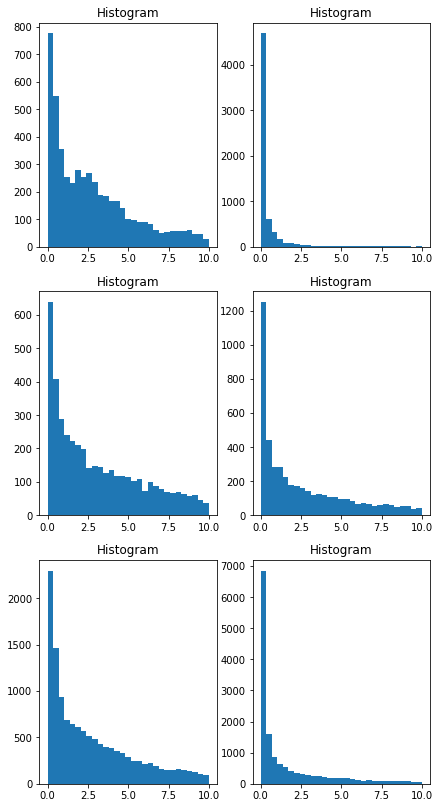

In [593]:
bins = np.linspace(0,10,30)

plt.figure(figsize=(7,14))
plt.subplot(321)
[_,_,_] = errVB.sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(322)
[_,_,_] = errVb.sel(tracer_num=11).sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(323)
[_,_,_] = errVB.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(324)
[_,_,_] = errVb.sel(tracer_num=11).sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(325)
[_,_,_] = errVB.plot.hist(bins=bins)

plt.subplot(326)
[_,_,_] = errVb.sel(tracer_num=11).plot.hist(bins=bins)


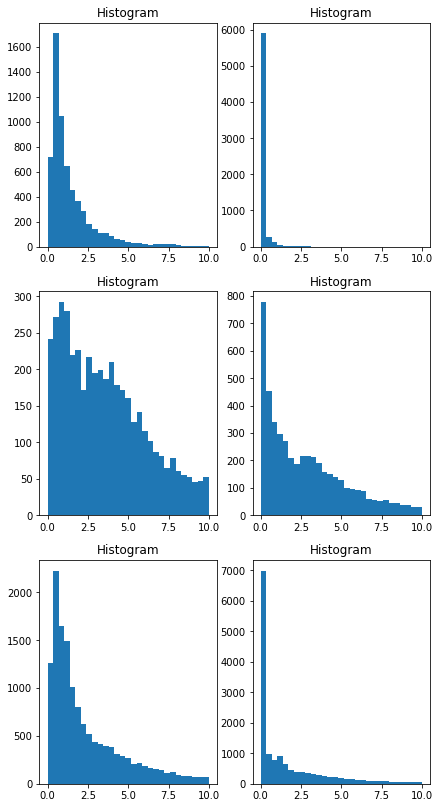

In [572]:
bins = np.linspace(0,10,30)

plt.figure(figsize=(7,14))
plt.subplot(321)
[_,_,_] = errWB.sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(322)
[_,_,_] = errWb.sel(tracer_num=11).sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(323)
[_,_,_] = errWB.sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(324)
[_,_,_] = errWb.sel(tracer_num=11).sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(325)
[_,_,_] = errWB.plot.hist(bins=bins)

plt.subplot(326)
[_,_,_] = errWb.sel(tracer_num=11).plot.hist(bins=bins)


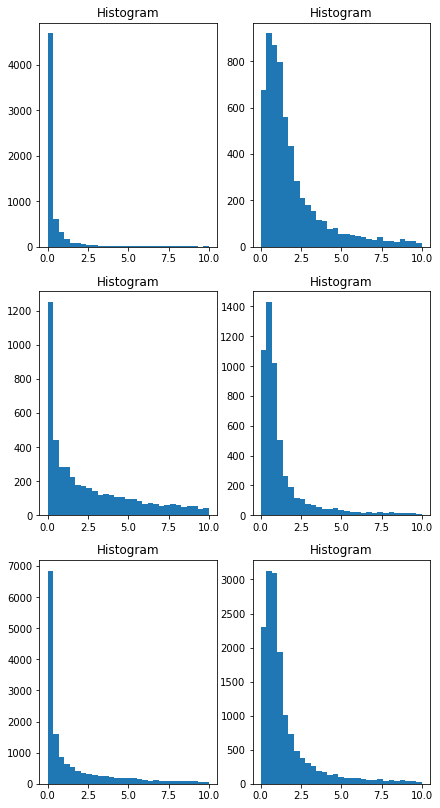

In [580]:
bins = np.linspace(0,10,30)

plt.figure(figsize=(7,14))
plt.subplot(321)
[_,_,_] = errVb.sel(tracer_num=11).sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(322)
[_,_,_] = errVb_skew.sel(tracer_num=11).sel(Z=slice(0,-500)).plot.hist(bins=bins)

plt.subplot(323)
[_,_,_] = errVb.sel(tracer_num=11).sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(324)
[_,_,_] = errVb_skew.sel(tracer_num=11).sel(Z=slice(-500,-2000)).plot.hist(bins=bins)

plt.subplot(325)
[_,_,_] = errVb.sel(tracer_num=11).plot.hist(bins=bins)

plt.subplot(326)
[_,_,_] = errVb_skew.sel(tracer_num=11).plot.hist(bins=bins)


# Calculate diffusivity tensor with buoyancy as a tracer

In [519]:
# Instead of keeping different tracer fluxes in dicitionaries, 
# we would like to put them into an xarray. This will help vectorize calculations
# and also easy in plotting. 

# Put fluxes into xarrays
# U'C'
testxr1 = mean_flux_stxav['UTRAC01']
testxr1['tracer_num'] = 1

UpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = mean_flux_stxav['U'+i]
    temp['tracer_num'] = n 
    n=n+1
    
    UpCp = xr.concat([UpCp, temp], dim='tracer_num')

temp = Tflux_stxav['UpTp']
temp['tracer_num'] = 11
UpCp = xr.concat([UpCp, temp], dim='tracer_num')

# V'C'
testxr1 = mean_flux_stxav['VTRAC01']
testxr1['tracer_num'] = 1

VpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = mean_flux_stxav['V'+i]
    temp['tracer_num'] = n 
    n=n+1
    
    VpCp = xr.concat([VpCp, temp], dim='tracer_num')

temp = Tflux_stxav['VpTp']
temp['tracer_num'] = 11
VpCp = xr.concat([VpCp, temp], dim='tracer_num')

# W'C'
testxr1 = mean_flux_stxav['WTRAC01']
testxr1['tracer_num'] = 1

WpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = mean_flux_stxav['W'+i]
    temp['tracer_num'] = n 
    n=n+1
    
    WpCp = xr.concat([WpCp, temp], dim='tracer_num')    

temp = Tflux_stxav['WpTp']
temp['tracer_num'] = 11
WpCp = xr.concat([WpCp, temp], dim='tracer_num')

In [526]:
# Put tracer gradients into xarrays
# dCdx
testxr1 = trac_grads['TRAC01_X']
testxr1['tracer_num'] = 1

dCdx = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = trac_grads[i+'_X']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdx = xr.concat([dCdx, temp], dim='tracer_num')
    
temp = Tgrads['T_X']
temp['tracer_num'] = 11
dCdx = xr.concat([dCdx, temp], dim='tracer_num')
    
# dCdy
testxr1 = trac_grads['TRAC01_Y']
testxr1['tracer_num'] = 1

dCdy = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = trac_grads[i+'_Y']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdy = xr.concat([dCdy, temp], dim='tracer_num')   

temp = Tgrads['T_Y']
temp['tracer_num'] = 11
dCdy = xr.concat([dCdy, temp], dim='tracer_num')

# dCdz
testxr1 = trac_grads['TRAC01_Z']
testxr1['tracer_num'] = 1

dCdz = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = trac_grads[i+'_Z']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdz = xr.concat([dCdz, temp], dim='tracer_num') 
    
temp = Tgrads['T_Z']
temp['tracer_num'] = 11
dCdz = xr.concat([dCdz, temp], dim='tracer_num') 

In [527]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)


Ktensorb = xr.apply_ufunc(calc_tensor, 
                       UpCp,
                       VpCp,
                       WpCp,
                       dCdx,
                       dCdy,
                       dCdz,
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensorb.load() # need to load because we will take transpose and add 

CPU times: user 3.8 s, sys: 69.7 ms, total: 3.87 s
Wall time: 3.86 s


In [552]:
# split into symmetric and asymmetric parts 

KtensorbT = Ktensorb.transpose('Xicoarse','Yicoarse','Z','j','i') 

STb = 0.5*(Ktensorb.data + KtensorbT.data)
ATb = 0.5*(Ktensorb.data - KtensorbT.data)

STb = xr.DataArray(STb, coords=Ktensorb.coords, dims=Ktensorb.dims)
ATb = xr.DataArray(ATb, coords=Ktensorb.coords, dims=Ktensorb.dims)

In [528]:
# Ktensor is R 

recUfluxb = Ktensorb.sel(i=0, j=0)*dCdx + Ktensorb.sel(i=0, j=1)*dCdy + Ktensorb.sel(i=0, j=2)*dCdz
recVfluxb = Ktensorb.sel(i=1, j=0)*dCdx + Ktensorb.sel(i=1, j=1)*dCdy + Ktensorb.sel(i=1, j=2)*dCdz
recWfluxb = Ktensorb.sel(i=2, j=0)*dCdx + Ktensorb.sel(i=2, j=1)*dCdy + Ktensorb.sel(i=2, j=2)*dCdz

errUb = np.abs(UpCp + recUfluxb)/np.abs(UpCp)
errVb = np.abs(VpCp + recVfluxb)/np.abs(VpCp)
errWb = np.abs(WpCp + recWfluxb)/np.abs(WpCp)

In [573]:
# Ktensor is R 

recUfluxb_skew = ATb.sel(i=0, j=0)*dCdx + ATb.sel(i=0, j=1)*dCdy + ATb.sel(i=0, j=2)*dCdz
recVfluxb_skew = ATb.sel(i=1, j=0)*dCdx + ATb.sel(i=1, j=1)*dCdy + ATb.sel(i=1, j=2)*dCdz
recWfluxb_skew = ATb.sel(i=2, j=0)*dCdx + ATb.sel(i=2, j=1)*dCdy + ATb.sel(i=2, j=2)*dCdz

errUb_skew = np.abs(UpCp + recUfluxb_skew)/np.abs(UpCp)
errVb_skew = np.abs(VpCp + recVfluxb_skew)/np.abs(VpCp)
errWb_skew = np.abs(WpCp + recWfluxb_skew)/np.abs(WpCp)

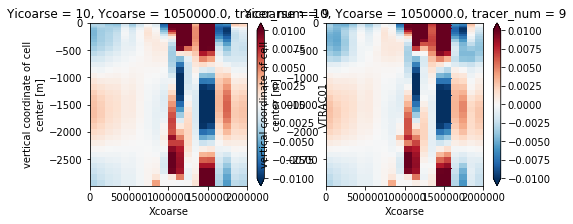

In [596]:
plt.figure(figsize=(12,3))

plt.subplot(131)
VpCp.sel(tracer_num=9).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.01)

plt.subplot(132)
(-recVfluxb.sel(tracer_num=9)).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.01)

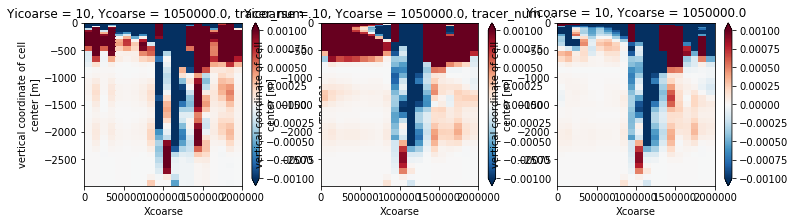

In [582]:
plt.figure(figsize=(12,3))

plt.subplot(131)
VpCp.sel(tracer_num=11).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

plt.subplot(132)
(-recVfluxb_skew.sel(tracer_num=11)).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

plt.subplot(133)
(-recVB_skew).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

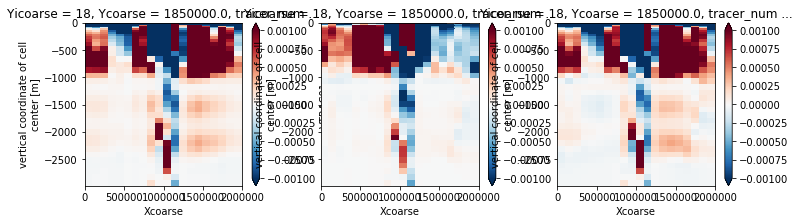

In [586]:
plt.figure(figsize=(12,3))

plt.subplot(131)
VpCp.sel(tracer_num=11).isel(Yicoarse=18).plot(x='Xcoarse',y='Z', vmin=-0.001)

plt.subplot(132)
(-recVfluxb_skew.sel(tracer_num=11)).isel(Yicoarse=18).plot(x='Xcoarse',y='Z', vmin=-0.001)

plt.subplot(133)
(-recVfluxb.sel(tracer_num=11)).isel(Yicoarse=18).plot(x='Xcoarse',y='Z', vmin=-0.001)

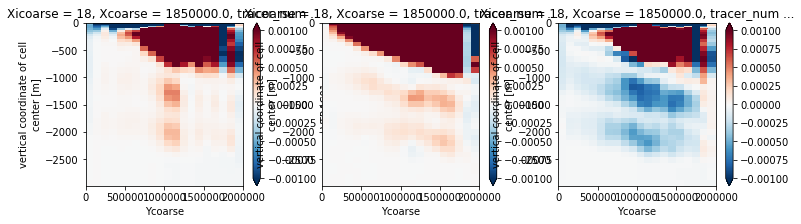

In [588]:
plt.figure(figsize=(12,3))

plt.subplot(131)
VpCp.sel(tracer_num=11).isel(Xicoarse=18).plot(x='Ycoarse',y='Z', vmin=-0.001)

plt.subplot(132)
(-recVfluxb_skew.sel(tracer_num=11)).isel(Xicoarse=18).plot(x='Ycoarse',y='Z', vmin=-0.001)

plt.subplot(133)
(-recVfluxb.sel(tracer_num=11)).isel(Xicoarse=18).plot(x='Ycoarse',y='Z', vmin=-0.001)

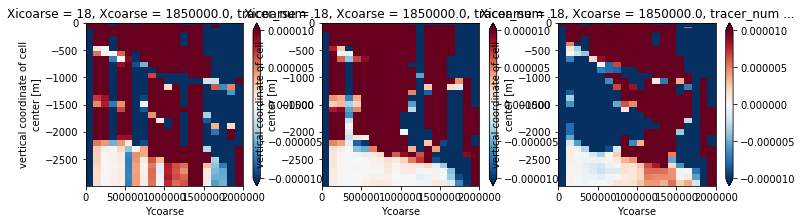

In [591]:
plt.figure(figsize=(12,3))

plt.subplot(131)
UpCp.sel(tracer_num=11).isel(Xicoarse=18).plot(x='Ycoarse',y='Z', vmin=-1e-5)

plt.subplot(132)
(-recUfluxb_skew.sel(tracer_num=11)).isel(Xicoarse=18).plot(x='Ycoarse',y='Z', vmin=-1e-5)

plt.subplot(133)
(-recUfluxb.sel(tracer_num=11)).isel(Xicoarse=18).plot(x='Ycoarse',y='Z', vmin=-1e-5)

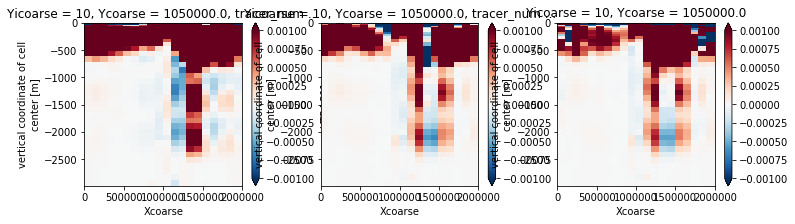

In [583]:
plt.figure(figsize=(12,3))

plt.subplot(131)
UpCp.sel(tracer_num=11).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

plt.subplot(132)
(-recUfluxb_skew.sel(tracer_num=11)).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

plt.subplot(133)
(-recUB_skew).isel(Yicoarse=10).plot(x='Xcoarse',y='Z', vmin=-0.001)

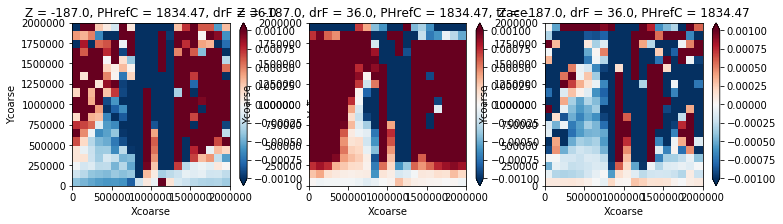

In [575]:
plt.figure(figsize=(12,3))

plt.subplot(131)
Tflux_stxav['VpTp'].isel(Z=10).plot(x='Xcoarse',y='Ycoarse', vmin=-0.001)

plt.subplot(132)
(-recVfluxb_skew.sel(tracer_num=11)).isel(Z=10).plot(x='Xcoarse',y='Ycoarse', vmin=-0.001)

plt.subplot(133)
(-recVB_skew).isel(Z=10).plot(x='Xcoarse',y='Ycoarse', vmin=-0.001)

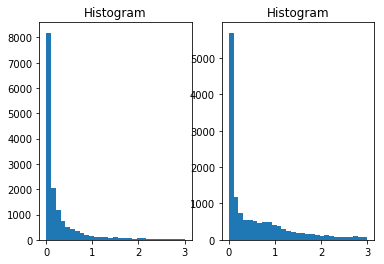

In [576]:
bins = np.linspace(0,3,30)

plt.subplot(121)
[_,_,_] = errUb.sel(tracer_num=10).plot.hist(bins=bins)

plt.subplot(122)
[_,_,_] = errUb.sel(tracer_num=11).plot.hist(bins=bins)

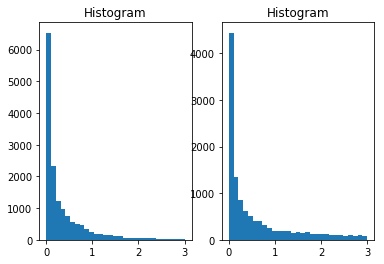

In [538]:
bins = np.linspace(0,3,30)

plt.subplot(121)
[_,_,_] = errVb.sel(tracer_num=3).plot.hist(bins=bins)

plt.subplot(122)
[_,_,_] = errVb.sel(tracer_num=11).plot.hist(bins=bins)

# QG relationship between PV and Redi fluxes

# Decomposition into sym and asym

In [182]:
# split into symmetric and asymmetric parts 

KtensorT = Ktensor.transpose('Xicoarse','Yicoarse','Z','j','i') 

ST = 0.5*(Ktensor.data + KtensorT.data)
AT = 0.5*(Ktensor.data - KtensorT.data)

ST = xr.DataArray(ST, coords=Ktensor.coords, dims=Ktensor.dims)
AT = xr.DataArray(AT, coords=Ktensor.coords, dims=Ktensor.dims)

In [183]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsST, eigvecsST = xr.apply_ufunc(eig, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [184]:
def sort_ev(x, xvec):
    xreal = x.real
    y = np.abs(xreal)
    if not np.isnan(y).any():
        z = y.argsort(axis=-1)
        return xreal[z.data], xvec[:,z.data]
    else:
        return xreal, xvec

In [185]:
# the eigenvectors have been arranged based on their magnitudes, while we want to arrange based on absolute magnitude
# so we need to resort 
evalsST, evecsST = xr.apply_ufunc(sort_ev, eigvalsST, eigvecsST, input_core_dims=[['ii'],['k','ii']]
                       , output_core_dims=[['ii'],['k','ii']], vectorize=True)
# now the eigenvalues are arranged from smallest to largest. 

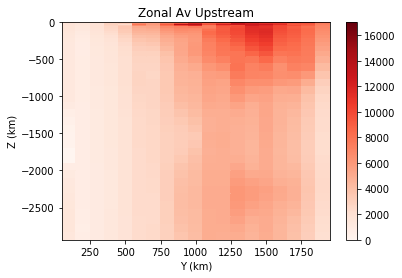

In [192]:
Xc = evalsST.Xcoarse
Yc = evalsST.Ycoarse

plt.pcolormesh(Xc/1e3, Z, (evalsST.isel(ii=2)).isel(Xicoarse=0).T, vmin=0, vmax=17000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()



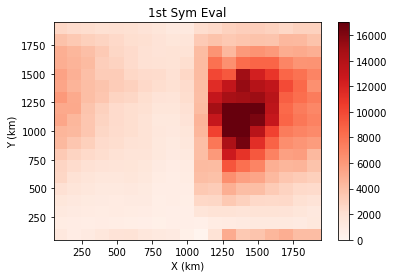

In [201]:
plt.pcolormesh(Xc/1e3, Yc/1e3, (evalsST.isel(ii=2)).sel(Z=-1000, method='nearest').T, vmin=0, vmax=17000,  cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('1st Sym Eval')
plt.colorbar()

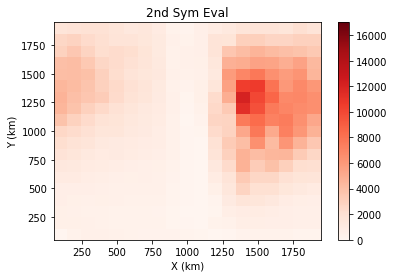

In [200]:
plt.pcolormesh(Xc/1e3, Yc/1e3, (evalsST.isel(ii=1)).sel(Z=-1000, method='nearest').T, vmin=0, vmax=17000,  cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('2nd Sym Eval')
plt.colorbar()

Text(0.5, 1.0, '2nd/1st Sym Eval')

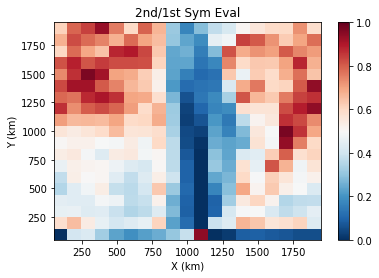

In [204]:
# ratio 

plt.pcolormesh(Xc/1e3, Yc/1e3, (evalsST.isel(ii=1)/evalsST.isel(ii=2)).sel(Z=-1000, method='nearest').T,
               vmin=0, vmax=1, cmap='RdBu_r')
plt.colorbar()

plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('2nd/1st Sym Eval')

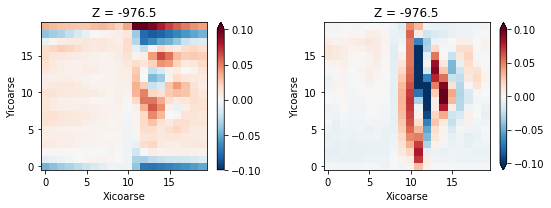

In [615]:
plt.figure(figsize=(8,3))
plt.subplot(121)
Umeansav.sel(Z=-1000, method='nearest').plot(vmin=-0.1)

plt.subplot(122)
Vmeansav.sel(Z=-1000, method='nearest').plot(vmin=-0.1)
plt.tight_layout()

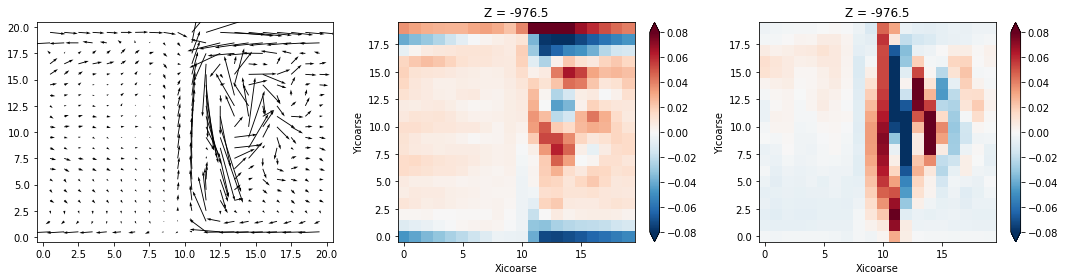

In [632]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.quiver(Xc/1e5, Yc/1e5, Umeansav.sel(Z=-1000, method='nearest').values, 
           Vmeansav.sel(Z=-1000, method='nearest').values, scale=0.7)

plt.subplot(132)
Umeansav.sel(Z=-1000, method='nearest').plot(vmin=-0.08)

plt.subplot(133)
Vmeansav.sel(Z=-1000, method='nearest').plot(vmin=-0.08)
plt.tight_layout()

plt.savefig('flow_1000m.pdf', dpi=25)

In [1006]:
# get psi1, 2 and 3 

psi1 = (AT[:,:,:,1,2])
psi2 = (-AT[:,:,:,0,2])
psi3 = (AT[:,:,:,0,1])

In [ ]:
# Set psi3 to zero in a reduced tensor
AT_reduce = AT.data.copy()
AT_reduce[:,:,:,0,1] = 0. 
AT_reduce[:,:,:,1,0] = 0. 
AT_reduce = xr.DataArray(AT_reduce, coords=Ktensor.coords, dims=Ktensor.dims)

In [ ]:
# Calculate the eigen values of the reduced tensor
eigvalsAT_reduce, eigvecsAT_reduce = xr.apply_ufunc(eig, AT_reduce, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [ ]:
# Calculate the isopycnal slopes
Tgrad = tracer_grads(Model_tav.Ttave, ds_model)

S_x = - Tgrad['dcdx']/Tgrad['dcdz']
S_y = - Tgrad['dcdy']/Tgrad['dcdz']
S_mag = (S_x**2 + S_y**2)**0.5

S_x.load()
S_y.load()
S_mag.load()


In [815]:
# Gm diffusivity 
Kgm = np.abs(eigvalsAT_reduce).max('ii')/S_mag
Kgm_approx = np.abs(eigvalsAT_reduce).max('ii')/(S_mag.sel(Z=slice(-500,-2000)).mean('Z'))

2

# Figures of diffusivities and eigen vectors below this 

## 1st eigenvalue of Symmetric tensor

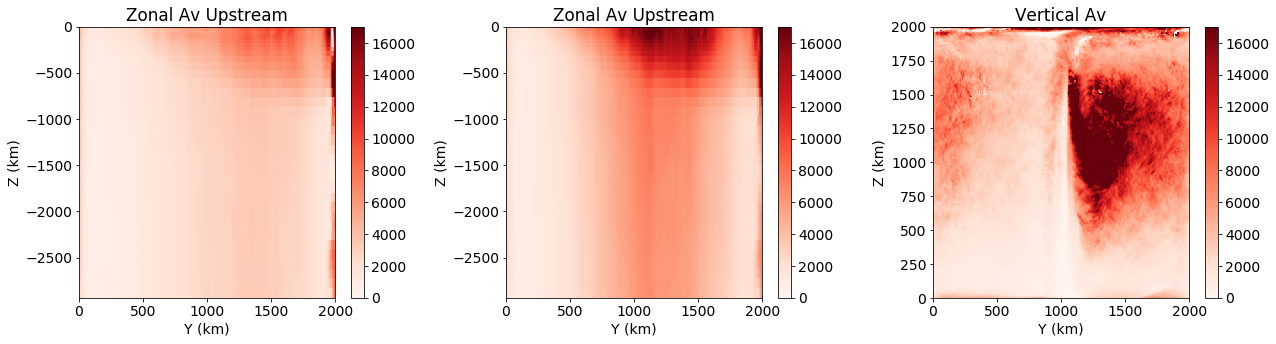

In [993]:
# Averaged plots 

fig = plt.figure(figsize = (18,5))

fig.add_subplot(131)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=2)*ds_model.hFacC).sel(XC=slice(0,800e3)).mean('XC'), vmin=0, vmax=17000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(132)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=2)*ds_model.hFacC).sel(XC=slice(1200,2000e3)).mean('XC'), vmin=0, vmax=17000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(133)
plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=2)*ds_model.hFacC).mean('Z'), vmin=0, vmax=17000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Vertical Av')
plt.colorbar()

plt.tight_layout()

## 2nd eigen value of Symmetric Tensor

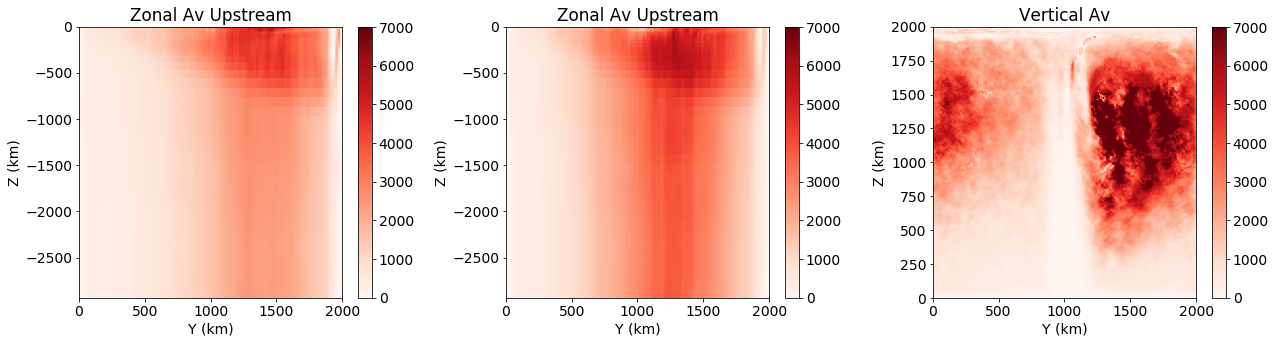

In [998]:
# Averaged plots 

fig = plt.figure(figsize = (18,5))

fig.add_subplot(131)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=1)*ds_model.hFacC).sel(XC=slice(0,800e3)).mean('XC'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(132)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=1)*ds_model.hFacC).sel(XC=slice(1200,2000e3)).mean('XC'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(133)
plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=1)*ds_model.hFacC).mean('Z'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Vertical Av')
plt.colorbar()

plt.tight_layout()
#plt.savefig('Kredi_5km_res.pdf', dpi=50)


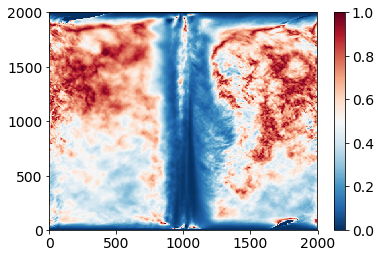

In [1176]:
# ratio 

plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=1)/evalsST.isel(ii=2)).sel(Z=-1000, method='nearest'),
               vmin=0, vmax=1, cmap='RdBu_r')
plt.colorbar()


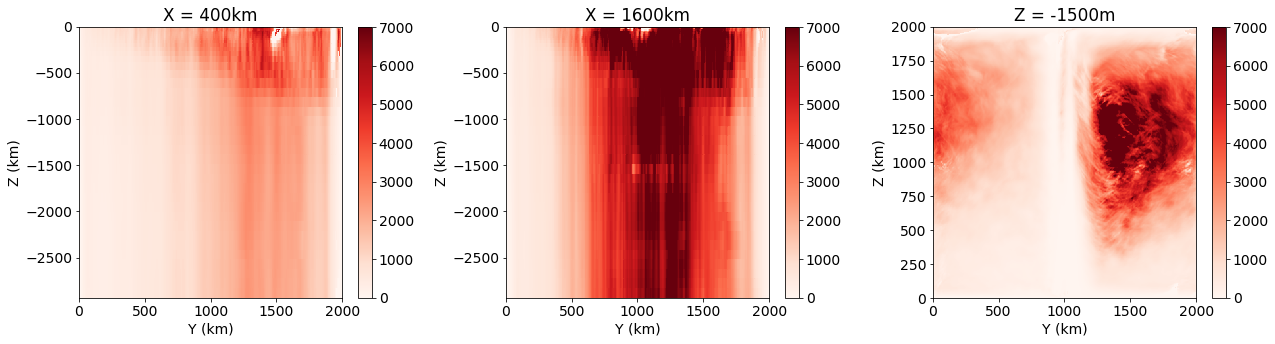

In [994]:
# Section plots 

fig = plt.figure(figsize = (18,5))

fig.add_subplot(131)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=1)*ds_model.hFacC).sel(XC=400e3, method='nearest'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('X = 400km')
plt.colorbar()

fig.add_subplot(132)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=1)*ds_model.hFacC).sel(XC=1600e3, method='nearest'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('X = 1600km')
plt.colorbar()

fig.add_subplot(133)
plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=1)*ds_model.hFacC).sel(Z=-1500, method='nearest'), vmin=0, vmax=7000,  cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Z = -1500m')
plt.colorbar()

plt.tight_layout()


# 3rd eigenvalue of Symmetric Tensor 
 
** the patchy structure observed here results from the  eigenvalues not being arranged perfectly, can be fixed easily. This is also the reason for some off points in the previous plots. **

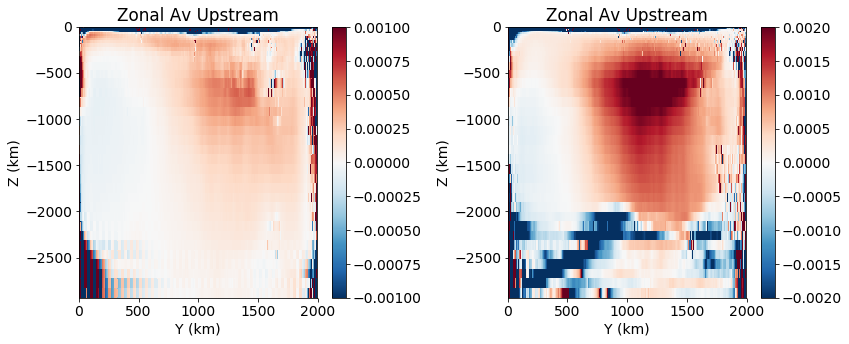

In [997]:
# Averaged plots 

fig = plt.figure(figsize = (12,5))

fig.add_subplot(121)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=0)*ds_model.hFacC).sel(XC=slice(0,800e3)).mean('XC'), vmin=-1e-3, vmax=1e-3,   cmap='RdBu_r')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(122)
plt.pcolormesh(X/1e3, Z, (evalsST.isel(ii=0)*ds_model.hFacC).sel(XC=slice(1400,1800e3)).mean('XC'),  vmin=-2e-3, vmax=2e-3, cmap='RdBu_r')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()



plt.tight_layout()
#plt.savefig('Kredi_5km_res.pdf', dpi=50)


What fraction of the strong "diapycnal" diffusivity is noise, vs true diapycnal transfer across mean isopycnals?

# Eigenvectors/ angles corresponding to the fluxes

What do we want to know about the eigen vectors of the symmetric matrix?  
does v1,v2,v3 form an orthogonal basis? **Yes, seems like it **

The coordinate system of the symmetric tensor is rotated in correspondence to the xyz. This rotation results from 2 angles. $\alpha$ and $\beta$. 

![Taken from Redi 1983](redi_1982_fig3.png)

Based on this coordinate $\alpha = \cos ^{-1} (\mathbf{v2}.\mathbf{j}/|\mathbf{v2}|)$

$\beta = \mathbf{v3}.\mathbf{k}$

In [1004]:
# Define some unit vectors
i  = np.array([1., 0., 0.])
j  = np.array([0., 1., 0.])
k  = np.array([0., 0., 1.])

In [1158]:
# angle to the horizontal 

v2 = evecsST.sel(ii=1)

v3 = evecsST.sel(ii=0)

dp = np.dot(np.abs(v2),j)
alpha = np.arccos(dp)

alpha = xr.DataArray(alpha, dims = v2.sel(k=0).dims, coords= v2.sel(k=0).coords)

dp = np.dot(v2,k)
beta = np.arccos(dp)

In [1169]:
v2.sel(XC=0, YC=1000e3, Z=-1000, method='nearest')

<xarray.DataArray (k: 3)>
array([-8.532599e-01,  5.214860e-01, -3.133434e-05], dtype=float32)
Coordinates:
    Z        float32 -976.5
    YC       float32 1002500.0
    XC       float32 2500.0
    rA       float32 25000000.0
    Depth    float32 2985.0
    drF      float32 103.0
    PHrefC   float32 9579.465
    hFacC    float32 1.0
Dimensions without coordinates: k

In [1160]:
Model_tav.ET

<xarray.Dataset>
Dimensions:   (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40)
Coordinates:
  * YC        (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG        (XG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * XC        (XC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * YG        (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
    dxG       (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    rA        (YC, XC) >f4 25000000.0 25000000.0 ... 25000000.0 25000000.0
    dyC       (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    rAz       (YG, XG) >f4 2500

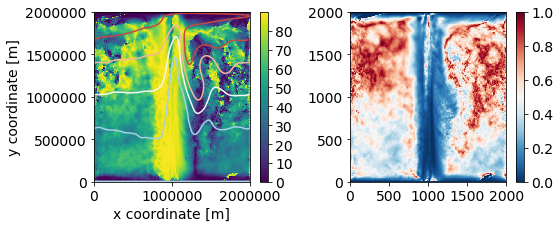

In [1178]:
plt.figure(figsize=(,3.4))

plt.subplot(121)
(alpha*180/np.pi).sel(Z=-1000, method='nearest').plot()
Model_tav.ETAtave.plot.contour()

plt.subplot(122)
plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=1)/evalsST.isel(ii=2)).sel(Z=-1000, method='nearest'),
               vmin=0, vmax=1, cmap='RdBu_r')
plt.colorbar()

plt.tight_layout()

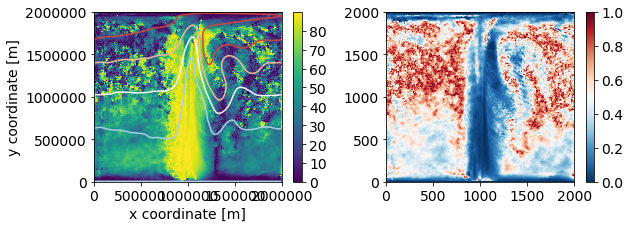

In [1180]:
plt.figure(figsize=(9,3.4))

plt.subplot(121)
(alpha*180/np.pi).sel(Z=-400, method='nearest').plot()
Model_tav.ETAtave.plot.contour()

plt.subplot(122)
plt.pcolormesh(X/1e3, Y/1e3, (evalsST.isel(ii=1)/evalsST.isel(ii=2)).sel(Z=-400, method='nearest'),
               vmin=0, vmax=1, cmap='RdBu_r')
plt.colorbar()

plt.tight_layout()

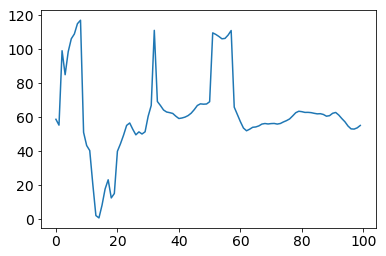

In [1132]:
plt.plot(alpha*180./np.pi)

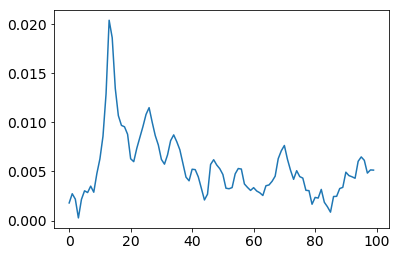

In [1150]:
plt.plot(np.abs(beta*180./np.pi-90))

In [1137]:
beta

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00048828, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
# Angle of the "vertical vector", corresponding to smallest eigval, to the horizontal direction. 



# Flow corresponding to psi 1

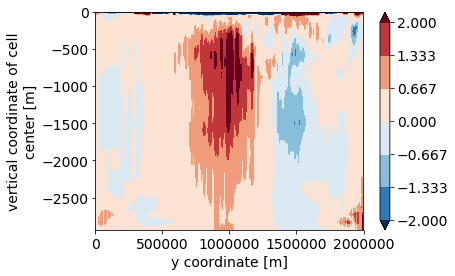

In [1098]:
psi1.sel(XC=slice(1200e3,1300e3)).mean('XC').plot.contourf(vmin=-2)

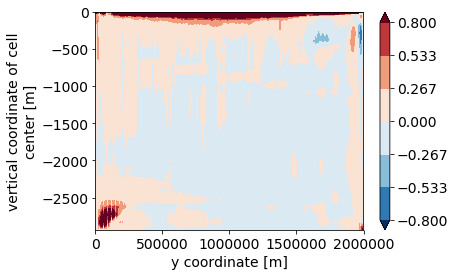

In [1103]:
psi1.sel(XC=slice(700e3,800e3)).mean('XC').plot.contourf(vmin=-0.8)

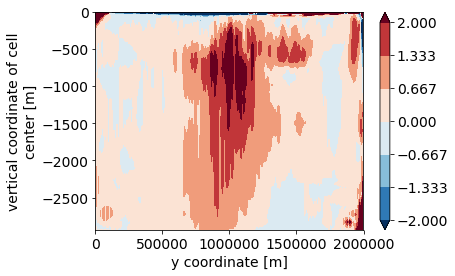

In [1100]:
psi2.sel(XC=slice(1200e3,1300e3)).mean('XC').plot.contourf(vmin=-2)

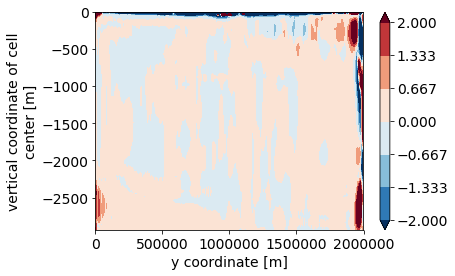

In [1181]:
psi2.sel(XC=slice(200e3,300e3)).mean('XC').plot.contourf(vmin=-2)

# Flow corresponding to psi 3 

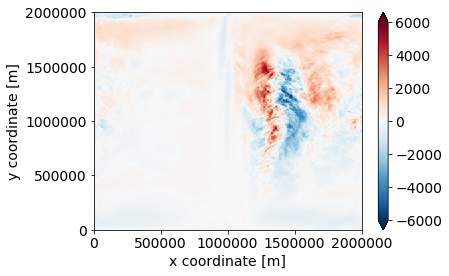

In [1024]:
psi3.sel(Z=slice(-700, -1700)).mean('Z').plot(vmin=-6000)

In [1013]:
# get velocity from psi3. 
dx = Model_tav.dxC[0,0]
Upsi3 = -grid.diff(psi3, 'Y', boundary='extend')/dx
Vpsi3 = grid.diff(psi3, 'X')/dx

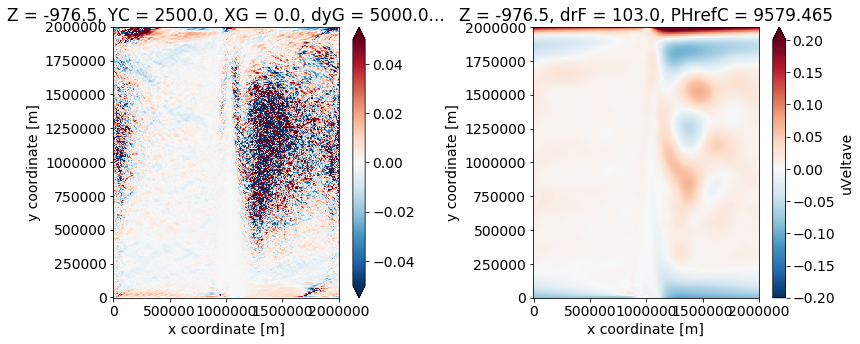

In [1021]:
fig = plt.figure(figsize=(12,5))

fig.add_subplot(121)
Upsi3.sel(Z=-1000, method='nearest').plot(vmin=-0.05)

fig.add_subplot(122)
Model_tav.uVeltave.sel(Z=-1000, method='nearest').plot(vmin=-0.2)

plt.tight_layout()

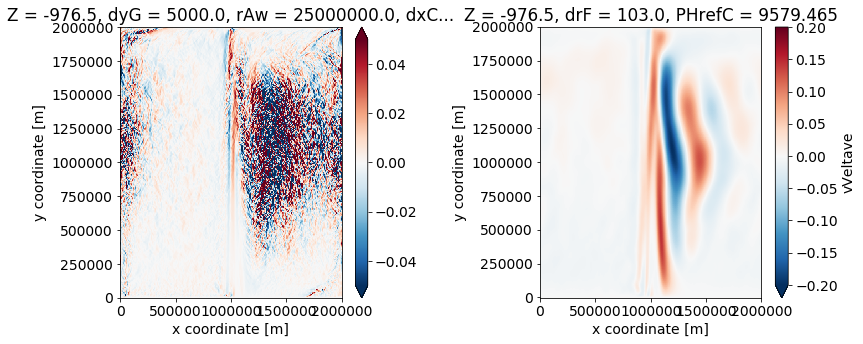

In [1022]:
fig = plt.figure(figsize=(12,5))

fig.add_subplot(121)
Vpsi3.sel(Z=-1000, method='nearest').plot(vmin=-0.05)

fig.add_subplot(122)
Model_tav.vVeltave.sel(Z=-1000, method='nearest').plot(vmin=-0.2)

plt.tight_layout()

It seems that the contribution of psi3 to the flow is small, about 10-20% of the mean flow, velocities. However, we need to do some smoothing to confirm numbers.

What might be of interest, is to confirm how psi3 aligns to geostrophic flows. If the contours are parallel, psi3 is simply a correction to mean velocity, but if psi3 is turned wrt the local geostrophic stream function it can be very important for the cross stream transport in the ACC. 

## Think about smoothing
The results here, while being very informative, are some what spatially noisy. To make better plots, and better approximate gradient quantities, it might make sense to use some sort of smoothing. Two alternatives are possible: analyze the tensor and then smooth, or smooth and then analyze. 

## Mixing Suppression

Channel models in the past have seen enhanced diffusivities at depth. For this to be the case one needs to have eddies that are advected with the mean flow. In our simulations we barely see that. 


In [1063]:
Eta_hov = ds_model.ETAtave.sel(
    YC=slice(950e3, 1150e3)).mean('YC').load()

In [1083]:
Eta_hov_1600 = ds_model.ETAtave.sel(
    YC=slice(1550e3, 1650e3)).mean('YC').load()

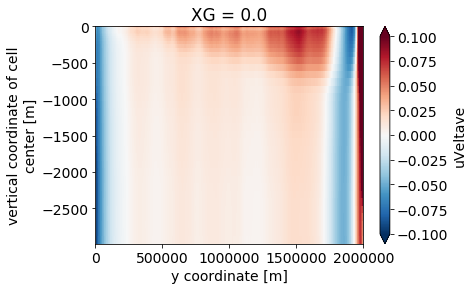

In [1082]:
Model_tav.uVeltave.sel(XG = 0, method='nearest').plot(vmin=-0.1)
plt.savefig('meanUatx0.pdf')

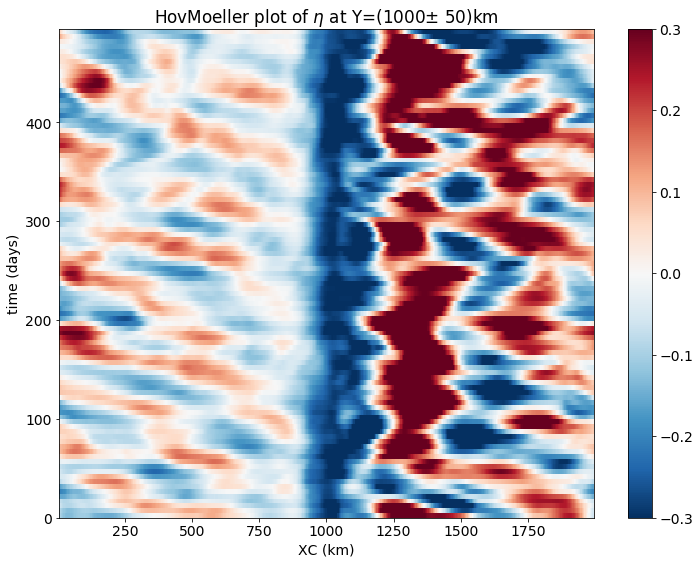

In [1069]:
plt.figure(figsize=(12,9))

tslice = slice(0,100)
plt.pcolormesh(Eta_hov.XC/1e3, Eta_hov.time.isel(time=tslice)/24/3600 - Eta_hov.time.isel(time=0)/24/3600 , 
               Eta_hov.isel(time=tslice), vmin=-0.3, vmax=0.3, cmap='RdBu_r')
plt.colorbar()
plt.xlabel('XC (km)')
plt.ylabel('time (days)')
plt.title('HovMoeller plot of $\eta$ at Y=(1000$\pm$ 50)km')

plt.savefig('Hovmoeller_eta.pdf')

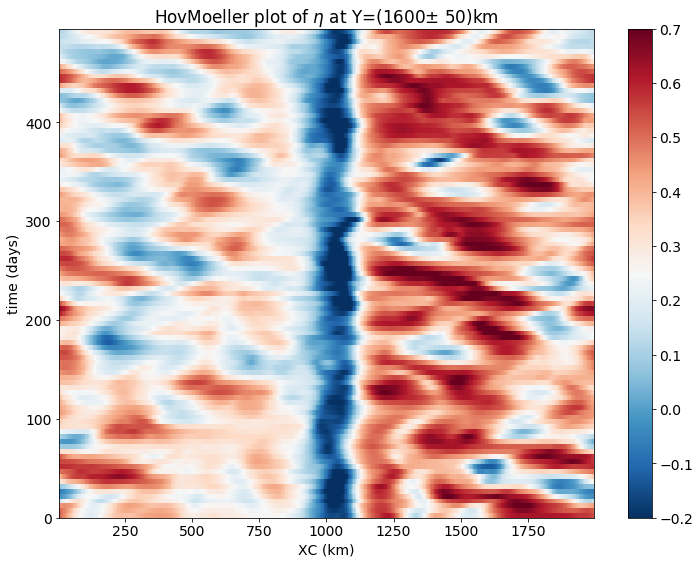

In [1088]:
plt.figure(figsize=(12,9))

tslice = slice(0,100)
plt.pcolormesh(Eta_hov.XC/1e3, Eta_hov.time.isel(time=tslice)/24/3600 - Eta_hov.time.isel(time=0)/24/3600 , 
               Eta_hov_1600.isel(time=tslice), vmin=-0.2, vmax=0.7, cmap='RdBu_r')
plt.colorbar()
plt.xlabel('XC (km)')
plt.ylabel('time (days)')
plt.title('HovMoeller plot of $\eta$ at Y=(1600$\pm$ 50)km')

plt.savefig('Hovmoeller_eta_1600.pdf')

(0, 5000.0)

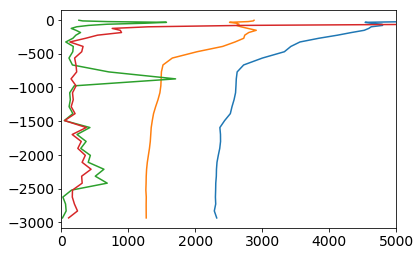

In [720]:
plt.plot((eigvalsST.isel(ii=0).real).sel(XC=500e3, YC=1000e3, method='nearest'), Z)

plt.plot((eigvalsST.isel(ii=1).real).sel(XC=500e3, YC=1000e3, method='nearest'), Z)
plt.plot((Kgm).sel(XC=500e3, YC=1000e3, method='nearest'), Z)
plt.plot((Kgm_approx).sel(XC=500e3, YC=1000e3, method='nearest'), Z)
plt.xlim([0,5e3])

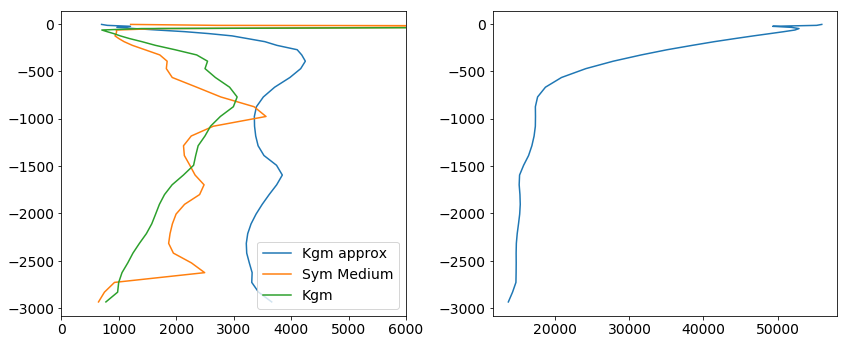

In [736]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot((eigvalsST.isel(ii=1).real).sel(XC=slice(1200e3, 1300e3), YC=slice(900e3, 1100e3)).mean(['XC','YC']), Z)
plt.plot((Kgm).sel(XC=slice(1200e3, 1300e3), YC=slice(900e3, 1100e3)).mean(['XC','YC']), Z)
plt.plot((Kgm_approx).sel(XC=slice(1200e3, 1300e3), YC=slice(900e3, 1100e3)).mean(['XC','YC']), Z)
plt.legend({'Sym Medium', 'Kgm', 'Kgm approx'})

plt.xlim([0,6e3])

plt.subplot(122)
plt.plot((eigvalsST.isel(ii=0).real).sel(XC=slice(1200e3, 1300e3), YC=slice(900e3, 1100e3)).mean(['XC','YC']), Z)

plt.tight_layout()


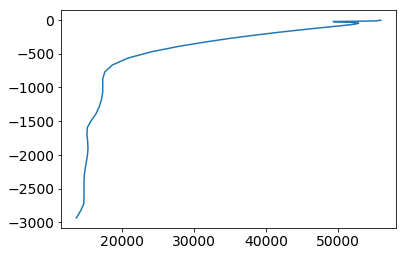

In [726]:
plt.plot((eigvalsST.isel(ii=0).real).sel(XC=slice(1200e3, 1300e3), YC=slice(900e3, 1100e3)).mean(['XC','YC']), Z)


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


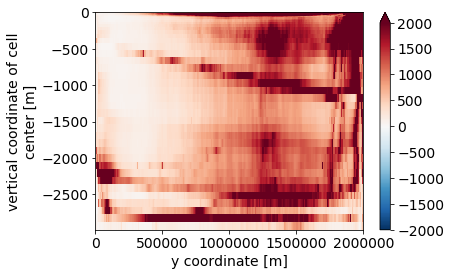

In [686]:
Kgm.mean('XC').plot(vmin=-2000, vmax=2000, cmap='RdBu_r')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


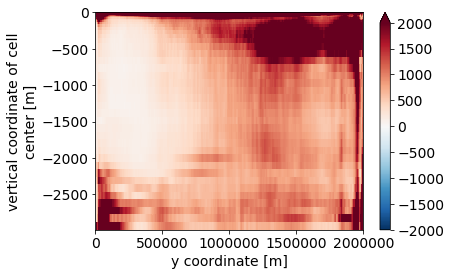

In [687]:
Kgm_approx.mean('XC').plot(vmin=-2000, vmax=2000, cmap='RdBu_r')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


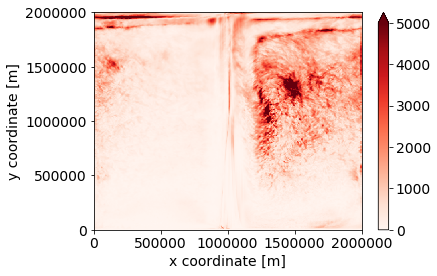

In [694]:
Kgm_approx.sel(Z=slice(-500,-2000)).mean('Z').plot(vmin=0, vmax=5000, cmap='Reds')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


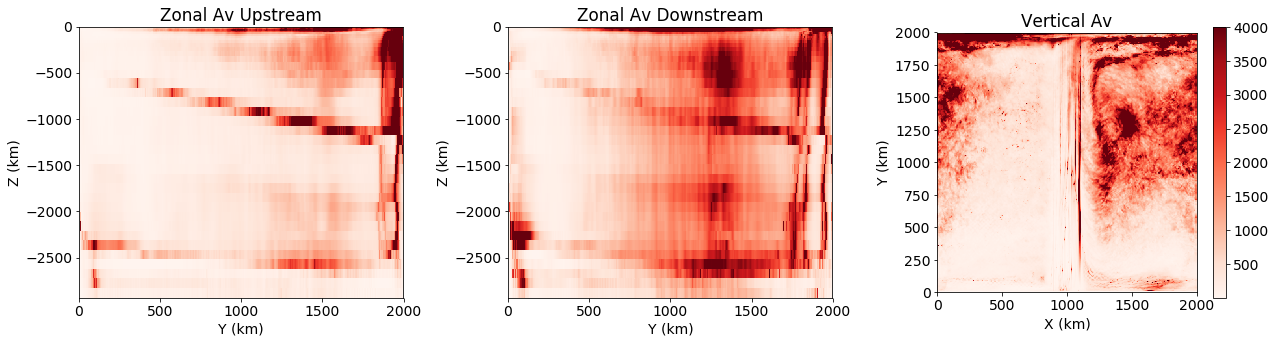

In [709]:
fig = plt.figure(figsize = (18,5))

fig.add_subplot(131)
plt.pcolormesh(X/1e3, Z, (Kgm.sel(XC=slice(0e3,800e3))*ds_model.hFacC).mean('XC'), vmax=4000, cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')

fig.add_subplot(132)
plt.pcolormesh(X/1e3, Z, (Kgm.sel(XC=slice(1200e3,2000e3))*ds_model.hFacC).mean('XC'), vmax=4000, cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Downstream')

ax = fig.add_subplot(133)
plt.pcolormesh(X/1e3, Y/1e3, (Kgm*ds_model.hFacC).mean('Z'),vmax=4000, cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Vertical Av')
ax.set_aspect('equal')
plt.colorbar()
plt.tight_layout()

plt.savefig('Kgm_5km_res.pdf', dpi=75)

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


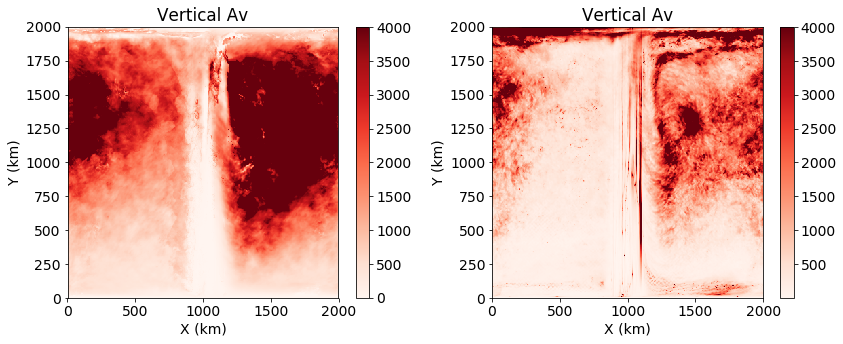

In [766]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
plt.pcolormesh(X/1e3, Y/1e3, (Kredi*ds_model.hFacC).mean('Z'),vmin=0, vmax=4000, cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Vertical Av')
ax.set_aspect('equal')
plt.colorbar()
plt.tight_layout()

ax = fig.add_subplot(122)
plt.pcolormesh(X/1e3, Y/1e3, (Kgm*ds_model.hFacC).mean('Z'),vmax=4000, cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Vertical Av')
ax.set_aspect('equal')
plt.colorbar()
plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


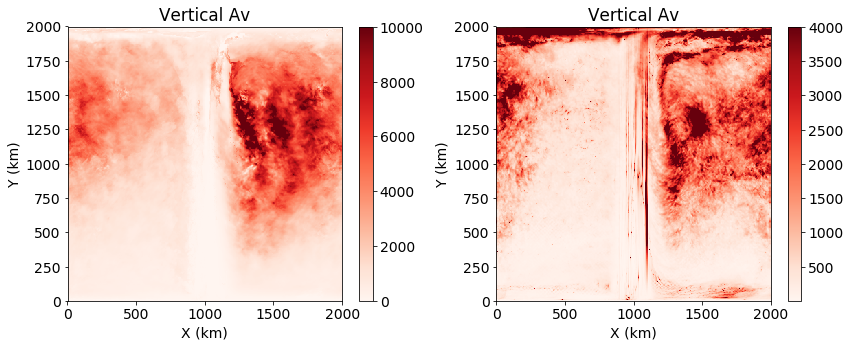

In [767]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
plt.pcolormesh(X/1e3, Y/1e3, (Kredi*ds_model.hFacC).mean('Z'),vmin=0, vmax=10000, cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Vertical Av')
ax.set_aspect('equal')
plt.colorbar()
plt.tight_layout()

ax = fig.add_subplot(122)
plt.pcolormesh(X/1e3, Y/1e3, (Kgm*ds_model.hFacC).mean('Z'),vmax=4000, cmap='Reds')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.title('Vertical Av')
ax.set_aspect('equal')
plt.colorbar()
plt.tight_layout()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


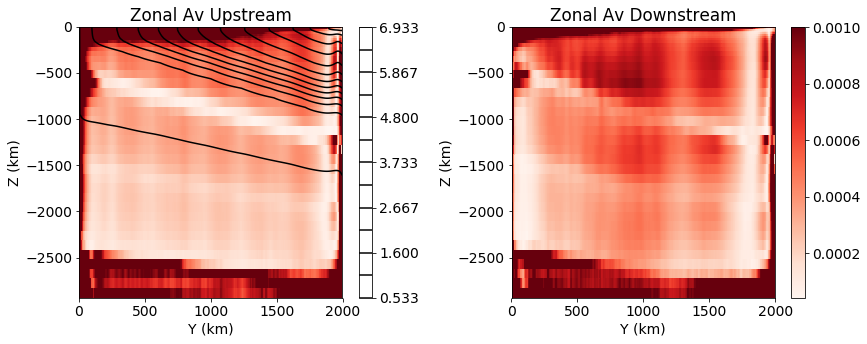

In [769]:
fig = plt.figure(figsize = (18,5))

fig.add_subplot(131)
plt.pcolormesh(X/1e3, Z, (S_mag.sel(XC=slice(0e3,800e3))*ds_model.hFacC).mean('XC'), vmax=1e-3, cmap='Reds')
plt.contour( X/1e3, Z, Model_tav.Ttave.sel(XC=slice(0e3,800e3)).mean('XC'), levels=np.linspace(0,8,16), colors='k')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Upstream')
plt.colorbar()

fig.add_subplot(132)
plt.pcolormesh(X/1e3, Z, (S_mag.sel(XC=slice(1200e3,2000e3))*ds_model.hFacC).mean('XC'), vmax=1e-3, cmap='Reds')
plt.xlabel('Y (km)')
plt.ylabel('Z (km)')
plt.title('Zonal Av Downstream')
plt.colorbar()

plt.tight_layout()

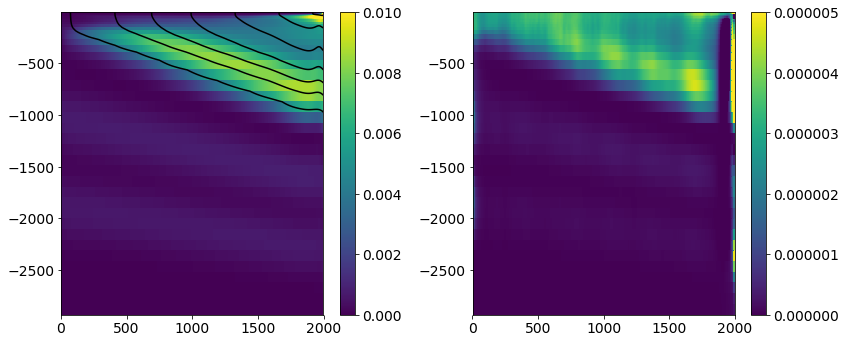

In [678]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.pcolormesh(X/1e3, Z, Tgrad['dcdz'].sel(XC=slice(0,800e3)).mean('XC'), vmax=0.01)
plt.colorbar()
plt.contour( X/1e3, Z, Model_tav.Ttave.sel(XC=slice(0e3,800e3)).mean('XC'), colors='k')

plt.subplot(122)
plt.pcolormesh(X/1e3, Z, Tgrad['dcdy'].sel(XC=slice(0,800e3)).mean('XC'), vmin=0, vmax=5e-6)
plt.colorbar()

plt.tight_layout()

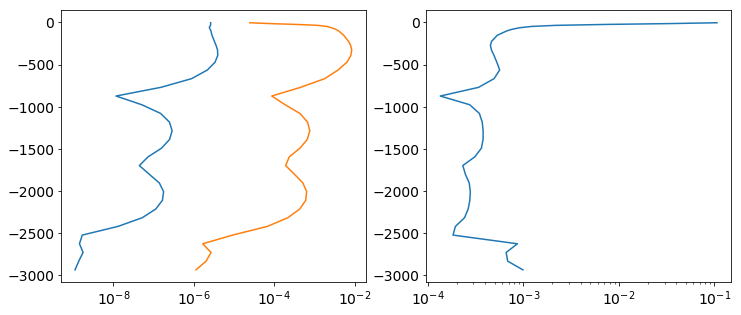

In [681]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(Tgrad['dcdy'].sel(XC=0, YC=1000e3, method='nearest'),Z)
plt.plot(Tgrad['dcdz'].sel(XC=0, YC=1000e3, method='nearest'),Z)
plt.xscale('log')


plt.subplot(122)
plt.plot((Tgrad['dcdy']/Tgrad['dcdz']).sel(XC=0, YC=1000e3, method='nearest'),Z)
plt.xscale('log')

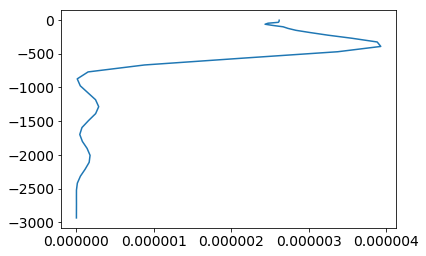

In [675]:
plt.plot(Tgrad['dcdy'].sel(XC=0, YC=1000e3, method='nearest'),Z)


# Check the buoyancy-PV relationship

\begin{equation}
K_q s_z = (K_bs)_z
\end{equation}

** This needs to be modified for the fields here **

In [740]:
# d/dz of lambda 

lambd = np.abs(eigvalsAT_reduce).max('ii')

lambd_z = grid.diff(lambd, 'Z', boundary='extend')/grid.diff(ds_model.Z, 'Z', boundary='extend')

In [748]:
s_z = grid.diff(S_mag, 'Z', boundary='extend')/grid.diff(ds_model.Z, 'Z', boundary='extend')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xgcm-0.1.0-py3.5.egg/xgcm/grid.py:880: RuntimeWarning: invalid value encountered in subtract


In [754]:
beta = 1.4e-11
f0  = -1.1e-4

In [750]:
Kredi_zl = grid.interp((eigvalsST.isel(ii=1).real), 'Z', boundary='extend')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


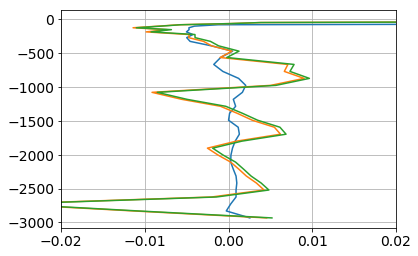

In [760]:
plt.plot(lambd_z.sel(XC=slice(1200e3,1400e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*s_z).sel(XC=slice(1200e3,1400e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*(s_z - beta/f0)).sel(XC=slice(1200e3,1400e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)

plt.xlim([-.02, 0.02])
plt.grid()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


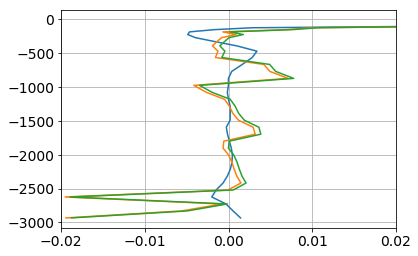

In [761]:
plt.plot(lambd_z.sel(XC=slice(1600e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*s_z).sel(XC=slice(1600e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*(s_z - beta/f0)).sel(XC=slice(1600e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)

plt.xlim([-.02, 0.02])
plt.grid()

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


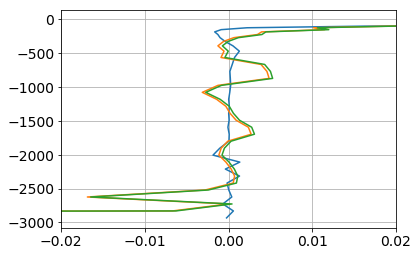

In [762]:
plt.plot(lambd_z.sel(XC=slice(0e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*s_z).sel(XC=slice(0e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)
plt.plot((Kredi_zl*(s_z - beta/f0)).sel(XC=slice(0e3,2000e3),YC=slice(900e3,1100e3)).mean(['XC','YC']), Z)

plt.xlim([-.02, 0.02])
plt.grid()

There are a few issues that are involved here:
- what do we aim to achieve out of these simulations? Is this meant to simply be a 3D extension of the 2D problem? 

Things to do: 
- Look at locality of fluxes. 
- How good is the K tensor at estimating the fluxes (what is the errors?)
- Look at 3D decomposition of SM2009
- Degree to which QG approximates the flux by looking at Eliassen-Palm fluxes. **this is in another notebook not **
- Visualize the flux vectors. Its a bit more challenging in the 3D case with non-zonal flows. 
- EKE, length scales, scalings. Diff scalings.
- phase speed, phase speed linear instability analaysis, critical layers.
- Does psi3 have a physical meaning? Think in terms of the Bolus velocity.

- Do we need to new runs with more constrained profiles? Why should the things not work here. 
